# Содержание

1. [Этап 1. Парсинг данных](#stage-1)
2. [Этап 2. Предварительная обработка](#stage-2)
3. [Этап 3. Разведывательный анализ данных](#stage-3)


<a id="stage-1"></a>

# Этап 1. Парсинг данных.

In [189]:
%pip install selenium webdriver-manager beautifulsoup4 pandas requests

import requests
from bs4 import BeautifulSoup
import pandas as pd
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import csv

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Для создания рабочего датасета собрали фильмы отсортированные по сборам в США года с 1975 по 2025.  
Примерное время парсинга 1,5 часа.  
Как работает парсер:  
1. Собираем ссылки на списки из 100 фильмов отсортированные по сборам на выбранные года.

2. Создаю csv файл, в которые буду записывать, полученную информацию.

3. С помощью селениум и вебдрайвер открывается страница списка из 100 фильмов в автоновном режиме, и собирает место из списка и ссылку на фильм. (Использовали селениум, так как через реквест выдавало только 25 фильмов, хотя в ссылке был параметр &count=100)

4. Алгоритм проходится по каждой ссылке и парсит такую информацию, как название, рейтинг, продолжительность в минутах, режисер, жанр, датарелиза, страна производства, компания производитель, бюджет, сборы в США, сборы по миру, сборы в первые выходные.
htmlтекст получаю через реквест. Cайт IMDB строиться частично динамически, почти все классы это уникальные строки, которые создаются при открытии ссылки, но у них есть неуникальный параметр {data_test_id}, поиск по которому и позволил получить большую часть информации.

5. После обработки одного года записываю информацию в файл и очищаю переменную data содержащую информацию о фильмах одного года.

In [190]:
start_year = 1975
end_year = 2025

Для примера можно взять 2 год.  
Примерное время парсинга 6-7 минут. 

In [191]:
start_year = 2016
end_year = 2017

1. Собираем ссылки на списки из 100 фильмов отсортированные по сборам на выбранные года.

In [192]:
count = 100

urls = list()

for year in range(start_year, end_year + 1):

    url = f"https://www.imdb.com/search/title/?title_type=feature&release_date={year}-01-01,{year}-12-31&count={count}&sort=boxoffice_gross_us,desc"
    urls.append(url)

In [193]:
print(*urls, sep='\n')

https://www.imdb.com/search/title/?title_type=feature&release_date=2016-01-01,2016-12-31&count=100&sort=boxoffice_gross_us,desc
https://www.imdb.com/search/title/?title_type=feature&release_date=2017-01-01,2017-12-31&count=100&sort=boxoffice_gross_us,desc


2. Создаю csv файл, в которые буду записывать, полученную информацию.

In [194]:
with open("test.csv", "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f, delimiter=';')
    csv_header = ['year', 'place', 'title', 'rating', 'min',
                    'director', 'genre', 'release_date', 'origin_country',
                    'company', 'budget', 'gross_us', 'gross_world', 'open_week']
    
    writer.writerow(csv_header)

4. Алгоритм проходится по каждой ссылке и парсит такую информацию, как название, рейтинг, продолжительность в минутах, режисер, жанр, датарелиза, страна производства, компания производитель, бюджет, сборы в США, сборы по миру, сборы в первые выходные.
htmlтекст получаю через реквест. Cайт IMDB строиться частично динамически, почти все классы это уникальные строки, которые создаются при открытии ссылки, но у них есть неуникальный параметр {data_test_id}, поиск по которому и позволил получить большую часть информации.

In [195]:
def get_info_from_url(html, headers, data):
    
    year = get_year(url)
    
    movie_url_start = "https://www.imdb.com"
    soup = BeautifulSoup(html, "html.parser")
    movies = soup.select(".ipc-metadata-list-summary-item")
    print(len(movies))
    
    for movie in movies:
        movie_data = list()
        movie_data.append(year)
        link = movie.select(".ipc-title-link-wrapper")[0]
        place = link.text.split('.')[0].strip()
        movie_data.append(place)

        movie_url = movie_url_start + link.get('href')   
        get_info_from_movie_url(movie_url, headers, movie_data)
        data.append(movie_data)
        print(movie_data[0], movie_data[1])


def get_info_from_movie_url(url, headers, movie_data):

    response = requests.get(url, headers=headers)
    soup = BeautifulSoup(response.text, "html.parser")
    title = get_text_from_class(soup, ".hero__primary-text")
   
    rating_obj = soup.find(attrs={"data-testid": "hero-rating-bar__aggregate-rating__score"})

    if type(rating_obj) != type(None):
        rating = rating_obj.find("span")
        if type(rating) != type(None):
            rating = rating.text
        else:
            rating = ''
    else:
        rating = ''

    genre_obj = soup.find(class_="ipc-chip-list__scroller")
    genre_list = list()
    if type(genre_obj) != type(None):
        for genre in genre_obj.find_all(class_="ipc-chip__text"):
            genre_list.append(genre.text)
    
    director = soup.find(class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link")
    if type(director) != type(None):
        director = director.text    
    else:
        director = ''


    details_section = soup.find(attrs={"data-testid": "title-details-section"})

    if type(details_section) != type(None):
        release_date_section = details_section.find(attrs={"data-testid": "title-details-releasedate"})
        if type(release_date_section) != type(None):
            release_date = release_date_section.find(class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text
        else:
            release_date = ''
        
        OriginCountry_section = details_section.find(attrs={"data-testid": "title-details-origin"})
        if type(OriginCountry_section) != type(None):
            OriginCountry = OriginCountry_section.find(class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text
        else:
            OriginCountry = ''

        Company_section = details_section.find(attrs={"data-testid": "title-details-companies"})
        if type(Company_section) != type(None):
            Company = Company_section.find(class_="ipc-metadata-list-item__list-content-item ipc-metadata-list-item__list-content-item--link").text
        else:
            Company = ''
    else:
        release_date = ''
        OriginCountry = ''
        Company = ''

    BoxOffice_section = soup.find(attrs={"data-testid": "title-boxoffice-section"})

    if type(BoxOffice_section) != type(None):
        budget_obj = BoxOffice_section.find(attrs={"data-testid": "title-boxoffice-budget"})
        if type(budget_obj) != type(None):
            budget = budget_obj.find(class_="ipc-metadata-list-item__list-content-item ipc-btn--not-interactable").text
        else:
            budget = ""

        grossdomestic_obj = BoxOffice_section.find(attrs={"data-testid": "title-boxoffice-grossdomestic"})
        if type(grossdomestic_obj) != type(None):
            grossdomestic = grossdomestic_obj.find(class_="ipc-metadata-list-item__list-content-item ipc-btn--not-interactable").text
        else:
            grossdomestic = ""

        openingweekenddomestic_obj = BoxOffice_section.find(attrs={"data-testid": "title-boxoffice-openingweekenddomestic"})
        if type(openingweekenddomestic_obj) != type(None):
            openingweekenddomestic = openingweekenddomestic_obj.find(class_="ipc-metadata-list-item__list-content-item ipc-btn--not-interactable").text
        else:
            openingweekenddomestic = ""

        cumulativeworldwidegross_obj = BoxOffice_section.find(attrs={"data-testid": "title-boxoffice-cumulativeworldwidegross"})
        if type(cumulativeworldwidegross_obj) != type(None):
            cumulativeworldwidegross = cumulativeworldwidegross_obj.find(class_="ipc-metadata-list-item__list-content-item ipc-btn--not-interactable").text
        else:
            cumulativeworldwidegross = ""
    else:
        budget = ""
        grossdomestic = ""
        openingweekenddomestic = ""
        cumulativeworldwidegross = ""

    runtime_section = soup.find(attrs={"data-testid": "title-techspec_runtime"})    
    if type(runtime_section) != type(None):
        runtime_min = runtime_section.find(class_="ipc-metadata-list-item__list-content-item--subText")
        if type(runtime_min) != type(None):
            runtime_min = runtime_min.text
        else:
            runtime_min = ''    
    else:
        runtime_min = ''

    movie_data.append(title.strip())
    movie_data.append(rating.strip())
    movie_data.append(runtime_min.strip())
    movie_data.append(director.strip())
    movie_data.append(genre_list)
    movie_data.append(release_date.strip())
    movie_data.append(OriginCountry.strip())
    movie_data.append(Company.strip())
    movie_data.append(budget.strip())
    movie_data.append(grossdomestic.strip())
    movie_data.append(cumulativeworldwidegross.strip())
    movie_data.append(openingweekenddomestic.strip())

    
    
def get_text_from_class(soup, soup_class):
    a_row = soup.select(soup_class)
    if len(a_row) > 0:
        a_row = a_row[0]
        text = a_row.text
    else:
        text = ""
    return text

def get_year(url):
    key = 'release_date='
    start = url.find(key)

    if start != -1:
        year = url[start + len(key): start + len(key) + 4]
    else:
        year = '0000'
    
    return year

3. С помощью селениум и вебдрайвер открывается страница списка из 100 фильмов в автоновном режиме, и собирает место из списка и ссылку на фильм. (Использовали селениум, так как через реквест выдавало только 25 фильмов, хотя в ссылке был параметр &count=100)

5.После обработки одного года записываю информацию в файл и очищаю переменную data содержащую информацию о фильмах одного года.

In [196]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/117.0",
    "Accept-Language": "en-US,en;q=0.9",
    "Referer": "https://www.imdb.com/",
}

for url in urls:
    data = list()
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    html = driver.page_source
    driver.quit()
    get_info_from_url(html, headers, data)
    print('data', data)

    with open("test.csv", "a", newline="", encoding="utf-8") as f:
        writer = csv.writer(f, delimiter=';')
        writer.writerows(data)


100
2016 1
2016 2
2016 3
2016 4
2016 5
2016 6
2016 7
2016 8
2016 9
2016 10
2016 11
2016 12
2016 13
2016 14
2016 15
2016 16
2016 17
2016 18
2016 19
2016 20
2016 21
2016 22
2016 23
2016 24
2016 25
2016 26
2016 27
2016 28
2016 29
2016 30
2016 31
2016 32
2016 33
2016 34
2016 35
2016 36
2016 37
2016 38
2016 39
2016 40
2016 41
2016 42
2016 43
2016 44
2016 45
2016 46
2016 47
2016 48
2016 49
2016 50
2016 51
2016 52
2016 53
2016 54
2016 55
2016 56
2016 57
2016 58
2016 59
2016 60
2016 61
2016 62
2016 63
2016 64
2016 65
2016 66
2016 67
2016 68
2016 69
2016 70
2016 71
2016 72
2016 73
2016 74
2016 75
2016 76
2016 77
2016 78
2016 79
2016 80
2016 81
2016 82
2016 83
2016 84
2016 85
2016 86
2016 87
2016 88
2016 89
2016 90
2016 91
2016 92
2016 93
2016 94
2016 95
2016 96
2016 97
2016 98
2016 99
2016 100
data [['2016', '1', 'Rogue One: A Star Wars Story', '7.8', '(133 min)', 'Gareth Edwards', ['Action Epic', 'Adventure Epic', 'Epic', 'Quest', 'Sci-Fi Epic', 'Space Sci-Fi', 'Tragedy', 'Action', 'Adventure'

KeyboardInterrupt: 

In [ ]:
df = pd.read_csv("test.csv", delimiter = ';')
df

,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week
0,2017,1,Star Wars: Episode VIII - The Last Jedi,6.8,(152 min),Rian Johnson,"['Action Epic', 'Adventure Epic', 'Epic', 'Fan...","December 15, 2017 (United States)",United States,Lucasfilm,"$317,000,000 (estimated)","$620,181,382","$1,334,407,706","$220,009,584"
1,2017,2,Beauty and the Beast,7.1,(129 min),Bill Condon,"['Dark Fantasy', 'Fairy Tale', 'Adventure', 'F...","March 17, 2017 (United States)",United States,Walt Disney Pictures,"$160,000,000 (estimated)","$504,481,165","$1,266,115,964","$174,750,616"
2,2017,3,Wonder Woman,7.3,(141 min),Patty Jenkins,"['Action Epic', 'Adventure Epic', 'Epic', 'Fan...","June 2, 2017 (United States)",United States,Warner Bros.,"$149,000,000 (estimated)","$412,845,172","$823,970,682","$103,251,471"
3,2017,4,Jumanji: Welcome to the Jungle,6.9,(119 min),Jake Kasdan,"['Body Swap Comedy', 'High-Concept Comedy', 'J...","December 20, 2017 (United States)",United States,Columbia Pictures,"$90,000,000 (estimated)","$404,540,171","$962,544,585","$36,169,328"
4,2017,5,Guardians of the Galaxy Vol. 2,7.6,(136 min),James Gunn,"['Space Sci-Fi', 'Superhero', 'Action', 'Adven...","May 5, 2017 (United States)",United States,Marvel Studios,"$200,000,000 (estimated)","$389,813,101","$863,764,214","$146,510,104"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2017,96,Phantom Thread,7.4,(130 min),Paul Thomas Anderson,"['Period Drama', 'Psychological Drama', 'Drama...","January 19, 2018 (United States)",United States,Focus Features,"$35,000,000 (estimated)","$21,198,205","$52,204,454","$216,495"
96,2017,97,The Disaster Artist,7.3,(104 min),James Franco,"['Dark Comedy', 'Docudrama', 'Period Drama', '...","December 8, 2017 (United States)",United States,Good Universe,"$10,000,000 (estimated)","$21,120,616","$29,820,616","$1,211,345"
97,2017,98,Sleepless,5.6,(95 min),Baran bo Odar,"['Car Action', 'Conspiracy Thriller', 'Action'...","January 13, 2017 (United States)",United States,Open Road Films (II),"$30,000,000 (estimated)","$20,783,704","$32,917,353","$8,344,128"
98,2017,99,Diary of a Wimpy Kid: The Long Haul,4.3,(91 min),David Bowers,"['Road Trip', 'Teen Adventure', 'Teen Comedy',...","May 19, 2017 (United States)",United States,Twentieth Century Fox,"$22,000,000 (estimated)","$20,738,724","$40,140,972","$7,126,084"


<a id="stage-2"></a>

# Этап 2. Предварительная обработка.


- Проанализируйте столбцы. Что в них содержится? Есть ли пропуски и где?
Обработайте пропуски, дубликаты, выбросы.
- Если в каком-то столбце пропусков большинство, то ее можно удалить.
- Сами пропуски/выбросы обработать: решите, удалить их или нет, заполнить медианой/средним или чем-нибудь еще, напишите, почему вы выбрали тот или иной вариант.

## 2.1. Поиск пропусков.

In [447]:
import numpy as np
import pandas as pd

# начальный датасет, чтобы прописать функцию 
df = pd.read_csv('imdb_data.csv', on_bad_lines='skip', delimiter = ';')


display(df.info())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4875 entries, 0 to 4874
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   year            4875 non-null   int64  
 1   place           4875 non-null   int64  
 2   title           4875 non-null   object 
 3   rating          4874 non-null   float64
 4   min             4866 non-null   object 
 5   director        4875 non-null   object 
 6   genre           4875 non-null   object 
 7   release_date    4874 non-null   object 
 8   origin_country  4871 non-null   object 
 9   company         4864 non-null   object 
 10  budget          4134 non-null   object 
 11  gross_us        4663 non-null   object 
 12  gross_world     4700 non-null   object 
 13  open_week       4346 non-null   object 
dtypes: float64(1), int64(2), object(11)
memory usage: 533.3+ KB


None

,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week
0,1975,1,Jaws,8.1,(124 min),Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...","June 20, 1975 (United States)",United States,Zanuck/Brown Productions,"$7,000,000 (estimated)","$280,083,300","$490,736,300","$7,061,513"
1,1975,2,The Rocky Horror Picture Show,7.4,(100 min),Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...","September 29, 1975 (United States)",United Kingdom,Twentieth Century Fox,"$1,200,000 (estimated)","$113,028,197","$116,574,698","$135,000"
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,(133 min),Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...","November 21, 1975 (United States)",United States,Fantasy Films,"$3,000,000 (estimated)","$108,981,275","$109,129,807",NaN
3,1975,4,Dog Day Afternoon,8.0,(125 min),Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...","December 25, 1975 (United States)",United States,Warner Bros.,"$1,800,000 (estimated)","$50,000,000","$50,009,617",NaN
4,1975,5,Shampoo,6.4,(110 min),Hal Ashby,"['Satire', 'Comedy', 'Drama']","March 13, 1975 (United States)",United States,Persky-Bright / Vista,"$4,000,000 (estimated)","$49,407,734","$49,407,734",NaN


## 2.2. Обработка пропусков.

### 2.2.1. Непроблемные пропуски - удаление пустых значений

- rating - 1, удалить
- release_date - 1, удалить
- origin_country и company - заменить пропуски на "Unknown"
- Остальные обработаем иначе.


In [448]:
df.dropna(subset='rating', inplace=True) #1
df.dropna(subset='release_date', inplace=True) #2

df = df.fillna({'origin_country': 'Unknown', 'company': 'Unknown'}) #3

# Вот тут изменения старых названий стран на новые
country_replace = {
    'Soviet Union': 'Russia',
    'West Germany': 'Germany',
    'Czechoslovakia': 'Czech Republic'
}
df['origin_country'] = df['origin_country'].replace(country_replace)

df.isna().sum()

year                0
place               0
title               0
rating              0
min                 8
director            0
genre               0
release_date        0
origin_country      0
company             0
budget            739
gross_us          211
gross_world       174
open_week         527
dtype: int64

### 2.2.2. Проблемные пропуски - обработка значений.

Заметим, что почти все (кроме min) пропуски - касаются валют. Их достаточно много и мы их не можем удалить. Это исказит данные. Обработаем их иначе.

In [449]:
df[df[['budget', 'gross_us', 'gross_world', 'open_week']].isna().any(axis=1)].head(5) # 

,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,(133 min),Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...","November 21, 1975 (United States)",United States,Fantasy Films,"$3,000,000 (estimated)","$108,981,275","$109,129,807",NaN
3,1975,4,Dog Day Afternoon,8.0,(125 min),Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...","December 25, 1975 (United States)",United States,Warner Bros.,"$1,800,000 (estimated)","$50,000,000","$50,009,617",NaN
4,1975,5,Shampoo,6.4,(110 min),Hal Ashby,"['Satire', 'Comedy', 'Drama']","March 13, 1975 (United States)",United States,Persky-Bright / Vista,"$4,000,000 (estimated)","$49,407,734","$49,407,734",NaN
5,1975,6,The Return of the Pink Panther,7.0,(113 min),Blake Edwards,"['Bumbling Detective', 'Farce', 'Globetrotting...","May 21, 1975 (United States)",United Kingdom,ITC Films,"$5,000,000 (estimated)","$41,833,347","$41,833,683",NaN
6,1975,7,Funny Lady,6.2,(136 min),Herbert Ross,"['Biography', 'Comedy', 'Drama', 'Musical', 'R...","March 15, 1975 (United States)",United States,Columbia Pictures,NaN,"$39,000,000","$39,000,000",NaN


#### 2.2.2.1. Обработка значений валют

1. Также признак budget - содержит сумму бюджета в валюте страны конкретного фильма, поэтому приведем к одной валюте (USD), пользуясь словарём-конвертером валют.
2. После чего [budget, gross_us, gross_world, open_week] - привести к int.

In [450]:
# функция приведения str к int
def str_to_int(x):
    s = str(x)
    digits = ''.join(ch for ch in s if ch.isdigit())
    return int(digits) if digits else np.nan

# функция для извлечения валюты
def extract_currency(x):
    if pd.isna(x):
        return np.nan
    s = str(x).replace('(estimated)', '').strip()
    currency = ''.join(ch for ch in s if not ch.isdigit() and ch not in ',. ')
    return currency if currency else np.nan

# приведение признаков, содержащих суммы денег к int
cash_columns = ['budget', 'gross_us', 'gross_world', 'open_week']
# валюту извлекаем отдельно для дальнейших преобразований
df['budget_currency'] = df['budget'].apply(extract_currency)

df[cash_columns] = df[cash_columns].apply(lambda x: x.apply(str_to_int))
df[cash_columns] = df[cash_columns].astype('Int64')

df.head(5)


,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget,gross_us,gross_world,open_week,budget_currency
0,1975,1,Jaws,8.1,(124 min),Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...","June 20, 1975 (United States)",United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513,$
1,1975,2,The Rocky Horror Picture Show,7.4,(100 min),Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...","September 29, 1975 (United States)",United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000,$
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,(133 min),Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...","November 21, 1975 (United States)",United States,Fantasy Films,3000000,108981275,109129807,<NA>,$
3,1975,4,Dog Day Afternoon,8.0,(125 min),Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...","December 25, 1975 (United States)",United States,Warner Bros.,1800000,50000000,50009617,<NA>,$
4,1975,5,Shampoo,6.4,(110 min),Hal Ashby,"['Satire', 'Comedy', 'Drama']","March 13, 1975 (United States)",United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>,$


In [451]:
df.rename(columns={'budget': 'budget_not_usd'}, inplace=True) # переименовываю, чтобы дальше не менять код коллег, тк все брали budget
country_year = df[['budget_currency', 'year']].drop_duplicates()
country_year = country_year[country_year['budget_currency'] != '$']


display(country_year.groupby('budget_currency')['year'].agg(min_year='min', max_year='max'))
print(country_year.groupby('budget_currency')['year'].unique())

,min_year,max_year
budget_currency,,
A$,1975,1981
CA$,1975,2023
DEM,1975,1981
FRF,1976,1997
HK$,1977,1991
ITL,1986,1997
NLG,1977,1977
NOK,1990,1990
PKR,2022,2022


budget_currency
A$                               [1975, 1977, 1978, 1981]
CA$     [1975, 1976, 1977, 1978, 1979, 1980, 1981, 198...
DEM                  [1975, 1976, 1977, 1978, 1979, 1981]
FRF                                    [1976, 1978, 1997]
HK$                                    [1977, 1978, 1991]
ITL                                          [1986, 1997]
NLG                                                [1977]
NOK                                                [1990]
PKR                                                [2022]
RUR                                          [1975, 1979]
£       [1975, 1976, 1977, 1979, 1980, 1982, 1983, 198...
¥                                                  [1979]
€                                [2007, 2020, 2021, 2022]
₹                          [1975, 2020, 2022, 2023, 2024]
Name: year, dtype: object


Словарь - ковертер валют (приведения к USD), составленный по данным со следющих сайтов:
- https://fx.sauder.ubc.ca/etc/USDpages.pdf 
- https://www.poundsterlinglive.com/bank-of-england-spot/historical-spot-exchange-rates/usd 
- https://web.archive.org/web/20130203063808/http://www.cbr.ru/currency_base/OldDataFiles/USD.xls 


In [452]:
usd_to_currency = {
    'A$': {
        1975: 0.7954,
        1977: 0.8761,
        1978: 0.8696,
        1981: 0.8868
    },
    'CA$': {
        1975: 0.9844,
        1976: 1.011,
        1977: 1.0944,
        1978: 1.1848,
        1979: 1.171,
        1980: 1.1944,
        1981: 1.1867,
        1982: 1.231,
        1987: 1.2997,
        2023: 1.3261
    },
    'DEM': {
        1975: 2.6187,
        1976: 2.3597,
        1977: 2.0925,
        1978: 1.82,
        1979: 1.726,
        1981: 2.2447
    },
    'FRF': {
        1976: 4.964,
        1978: 4.1675,
        1997: 6.0108
    },
    'HK$': {
        1977: 4.616,
        1978: 4.7965,
        1991: 7.779
    },
    'ITL': {
        1986: 1338,
        1997: 1766.41
    },
    'NLG': {
        1977: 2.2625
    },
    'NOK': {
        1990: 5.8815
    },
    'PKR': {
        2022: 226.7085
    },
    'RUR': {
        1975: 0.7580, 
        1979: 0.6440
    },
    '£': {
        1975: 0.4943,
        1976: 0.5875,
        1977: 0.5212,
        1979: 0.4494,
        1980: 0.4181,
        1982: 0.6182,
        1983: 0.6887,
        1984: 0.8636,
        1987: 0.5299,
        1988: 0.5531,
        1989: 0.6202,
        1992: 0.6601,
        1996: 0.5841,
        2000: 0.6689,
        2006: 0.511,
        2007: 0.5023
    },
    '¥': {
        1979: 239.65
    },
    '€': {
        2007: 0.684, 
        2020: 0.8146,
        2021: 0.8835, 
        2022: 0.9367
    },
    '₹': {
        1975: 8.3759, 
        2020: 73.0672,
        2022: 82.5735, 
        2023: 83.2165,
        2024: 85.5785
    } 
   
}

In [453]:
df['budget_currency'] = df['budget_currency'].str.strip()
def convert_to_usd(row):
    amount = row['budget_not_usd']
    currency = row['budget_currency']
    year = row['year']
    
    if pd.isna(amount) or currency == '$':
        return int(amount) if pd.notna(amount) else np.nan
    
    rate = usd_to_currency[currency][year]
    return int(amount / rate)

df['budget'] = df.apply(lambda row: convert_to_usd(row), axis=1)

df[(df['budget_currency'] != '$') & (df['budget_currency'].notna())].head(3)

,year,place,title,rating,min,director,genre,release_date,origin_country,company,budget_not_usd,gross_us,gross_world,open_week,budget_currency,budget
21,1975,22,Monty Python and the Holy Grail,8.2,(91 min),Terry Gilliam,"['Farce', 'Parody', 'Quest', 'Satire', 'Sketch...","July 18, 1975 (United States)",United Kingdom,Python (Monty) Pictures,229575,2562392,2934737,45487,£,464444.0
26,1975,27,Picnic at Hanging Rock,7.4,(115 min),Peter Weir,"['Coming-of-Age', 'Period Drama', 'Teen Drama'...","February 2, 1979 (United States)",Australia,British Empire Films Australia,440000,83212,199252,27492,A$,553180.0
29,1975,30,Mirror,7.9,(107 min),Andrei Tarkovsky,"['Russian', 'Biography', 'Drama']","March 7, 1975 (Soviet Union)",Russia,Mosfilm,622000,22168,126146,11537,RUR,820580.0


По выводу сверху видно как наш ковертер работает с другими валютами.
Также мы внесли изменения в признки датасета:

```python
'budget' # теперь содержит цену, переведенную в USD
'budget_not_usd' # бюджет в местной валюте
```

#### 2.2.2.2. Обработка значений длительности фильма

Приведение длительности (min), заполнение пропусков медианным значением, переименование признака в duration

In [454]:
df['min'] = df['min'].apply(lambda x: str_to_int(x))


df['min'] = df['min'].fillna(df['min'].median())
df = df.rename(columns={'min': 'duration'})
df['duration'] = df['duration'].astype('int64')

## 2.3. Приведение форматов создание новых признаков.

### 2.3.1. Приведение формата даты релиза

release_date - удалить строки, а после привести формат June 20, 1975 (United States) ---> pd.to_datetime()

In [455]:
# приведение признака release_date к datetime
def clean_date(s):
    if pd.isna(s):
        return None
    # убираем страну в скобках, если есть
    if "(" in s:
        s = s.split("(")[0].strip()

    info = s.split()
    month_dict = {
        'January': 1, 'February': 2, 'March': 3,
        'April': 4, 'May': 5, 'June': 6,
        'July': 7, 'August': 8, 'September': 9,
        'October': 10, 'November': 11, 'December': 12
    }
    # June 20, 1975
    if len(info) == 3:
        month = info[0]
        day = info[1].replace(",", "")
        year = info[2]
    # July 1975
    elif len(info) == 2:
        month = info[0]
        day = "15"   # условно середина месяца
        year = info[1]
    else:
        return None  # на крайний случай

    return f"{year}-{month_dict[month]}-{day}"

df['release_date'] = pd.to_datetime(df['release_date'].apply(lambda x: clean_date(x)))

df.dropna(subset=['release_date'], inplace=True)

# создать признак month, как будет полезе при анализе сезонности релизов фильмов
df['release_month'] = df['release_date'].dt.month

df.head(5)


,year,place,title,rating,duration,director,genre,release_date,origin_country,company,budget_not_usd,gross_us,gross_world,open_week,budget_currency,budget,release_month
0,1975,1,Jaws,8.1,124,Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,7000000,280083300,490736300,7061513,$,7000000.0,6
1,1975,2,The Rocky Horror Picture Show,7.4,100,Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,1200000,113028197,116574698,135000,$,1200000.0,9
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,133,Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,3000000,108981275,109129807,<NA>,$,3000000.0,11
3,1975,4,Dog Day Afternoon,8.0,125,Sidney Lumet,"['Dark Comedy', 'Heist', 'True Crime', 'Biogra...",1975-12-25,United States,Warner Bros.,1800000,50000000,50009617,<NA>,$,1800000.0,12
4,1975,5,Shampoo,6.4,110,Hal Ashby,"['Satire', 'Comedy', 'Drama']",1975-03-13,United States,Persky-Bright / Vista,4000000,49407734,49407734,<NA>,$,4000000.0,3


### 2.3.2. Приведение списка жанров к базовым

Избавляемся от множества различных жанров, оставляем лишь базовые. Т.к. после парсинга число жанров на каждый фильм - очень большое и разнообразоное. Поэтому произведем своего рода "нормализацию" списка жанров.

In [456]:

def make_genre_base(s):
    new_genre = []
    base_genres = ['comedy','musical', 'drama', 'horror', 
                   'action', 'romance', 'sci-fi', 'thriller', 
                   'adventure', 'animation', 'fantasy', 'western']

    for g in base_genres:
        if g in ''.join(s.lower()):
            new_genre.append(g)
    return new_genre

df['genre_base'] = df['genre'].apply(lambda x: make_genre_base(x))
df['genre_base'].head(5)


0    [horror, thriller, adventure]
1        [comedy, musical, horror]
2                  [comedy, drama]
3        [comedy, drama, thriller]
4                  [comedy, drama]
Name: genre_base, dtype: object

### 2.3.3. Обработка пустых признаков валют

Больше всего пропусков в budget, gross_us, gross_world, open_week. Но их удаление исказит данные. Поэтому оставим NaN и создадим бинарные признаки has_budget, has_gross_us, has_gross_world, has_open_week. К которым будем обращаться при работе с этими признаками.

In [457]:
cash_columns = ['budget', 'gross_us', 'gross_world', 'open_week']
for col in cash_columns:
    df[f'has_{col}'] = df[col].notna()

df.isna().sum()

year                 0
place                0
title                0
rating               0
duration             0
director             0
genre                0
release_date         0
origin_country       0
company              0
budget_not_usd     735
gross_us           205
gross_world        169
open_week          519
budget_currency    735
budget             735
release_month        0
genre_base           0
has_budget           0
has_gross_us         0
has_gross_world      0
has_open_week        0
dtype: int64

Созданы признаки: 

```python
has_budget        # флаг наличия данных о бюджете        
has_gross_us      # флаг наличия данных о сборах в США
has_gross_world   # флаг наличия данных о сборах в мире
has_open_week     # флаг наличия данных о сборах в первый уикенд
```

In [458]:
df.duplicated(subset=['title', 'year']).sum()


np.int64(0)

### 2.3.4. Проверка на выбросы

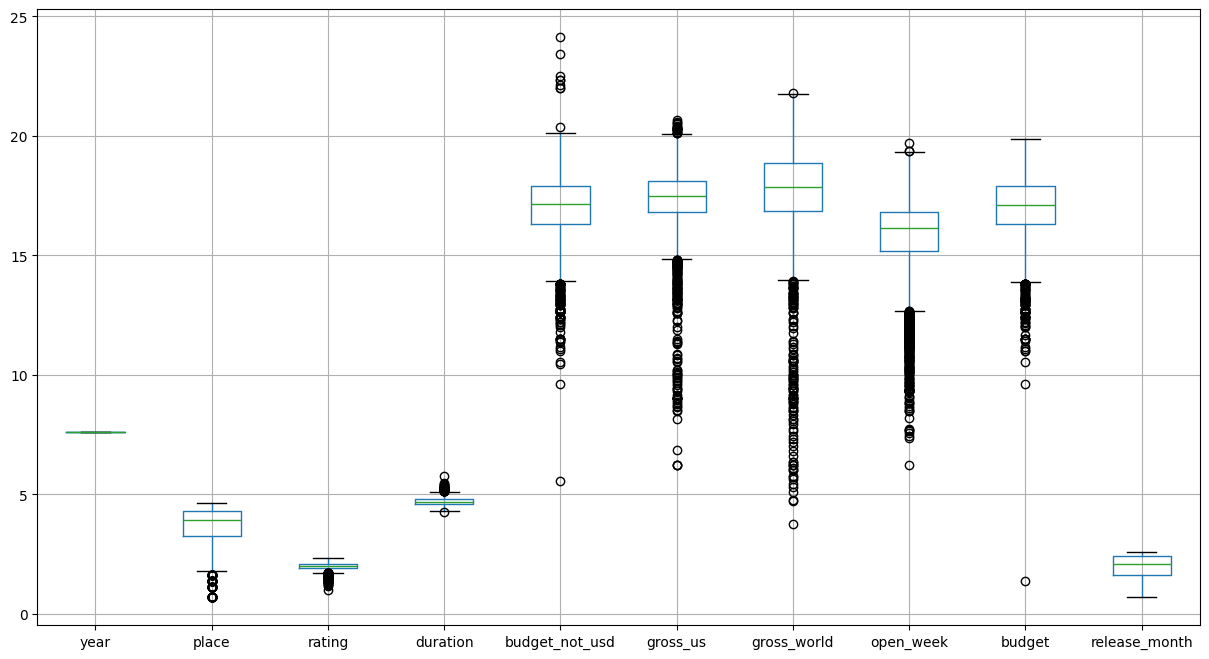

In [459]:
import matplotlib.pyplot as plt
import seaborn as sns

# посмотрю на распределения всех числовых типов и опеределю, где необходимо удалять выбросы
# для наглядности распределения логарифмирую
def plot_log_boxplots(df):
    num_df = df.select_dtypes(include=['number'])
    log_df = num_df.apply(lambda col: np.log(col + 1) if col.min() >= 0 else col)

    plt.figure(figsize=(15, 8))
    log_df.boxplot()
    plt.show()

plot_log_boxplots(df)

- Всё что касается денег (budget, gross_us, gross_world, open_week) - выбросы удалять не стоит. Т.к. у денег бюджетов и сборов такая специфика.
- release_month не может содержать выбросов т.к. это нами созданный столбец с данными в диапазоне (1-12).
- Аналогично, год, место и рейтинг, duration.

Однако можно заметить явный ошибочный выброс в бюджете. Это мин. значания на boxplot 'budget' и 'budget_not_usd'. Удалю его.


In [460]:
df[np.log(df['budget'] + 1) < 5][['title', 'year']]
df = df[np.log(df['budget'] + 1) >= 5]

### 2.3.5. Создание коэффициента возврата инвестиций

Создадим новый признак, который поможет судить об экономическом успехе фильма.

$$
ROI = \frac{\text{Доход} - \text{Затраты}}{\text{Затраты}} \times 100\%
$$


In [461]:
df['ROI'] = ((df['gross_world'] - df['budget']) / df['budget']) * 100

---

<a id="stage-3"></a>

# Этап 3. Разведывательный анализ данных + Визализация.
После обработки имеем датасет со следующими признаками:




Признаки для анализа

| Признак | Описание |
|--------|----------|
| **year** | Год выхода фильма |
| **place** | Позиция фильма в списке того года / внутренний рейтинг выборки |
| **title** | Название фильма |
| **rating** | Рейтинг IMDb |
| **duration** | Длительность фильма в минутах |
| **director** | Режиссёр фильма |
| **genre** | Полный список жанров фильма как на IMDb |
| **release_date** | Дата премьеры фильма (YYYY-MM-DD) |
| **origin_country** | Страна производства фильма |
| **company** | Студия / производственная компания |
| **budget_not_usd** | Бюджет фильма (в местной валюте) |
| **gross_us** | Кассовые сборы в США (USD) |
| **gross_world** | Мировые кассовые сборы (USD) |
| **open_week** | Сборы в первый уикенд (USD) |
| **budget_currency** | Местная валюта |
| **budget** |  Бюджет фильма (в USD) |
| **release_month** | Месяц выхода фильма (1–12) |
| **genre_base** | Нормализованные базовые жанры для анализа |
| **has_budget** | Флаг наличия данных о бюджете |
| **has_gross_us** | Флаг наличия данных о сборах в США |
| **has_gross_world** | Флаг наличия данных о мировых сборах |
| **has_open_week** | Флаг наличия данных о сборах в первый уикенд |
| **ROI** | Коэффициент возврата инвестиций |

In [471]:
df.dtypes

year                        int64
place                       int64
title                      object
rating                    float64
duration                    int64
director                   object
genre                      object
release_date       datetime64[ns]
origin_country             object
company                    object
budget_not_usd              Int64
gross_us                    Int64
gross_world                 Int64
open_week                   Int64
budget_currency            object
budget                    float64
release_month               int32
genre_base                 object
has_budget                   bool
has_gross_us                 bool
has_gross_world              bool
has_open_week                bool
ROI                       Float64
dtype: object

Приступим к анализу по следующему намеченному плану:

- 3.1. Базовое исследование

- 3.2. Бюджет → сборы → окупаемость  
  - 3.2.1. Связь бюджета и мировых сборов  
  - 3.2.2. Cвязь бюджета и возврата на инвестиции (ROI) 
  - 3.2.3. Анализ ROI  
    - 3.2.3.1. Топ 20 фильмов по окупаемости  
    - 3.2.3.2. Анализ бюджета по странам  
    - 3.2.3.3. Возврат инвестиций по жанрам  

- 3.3. Жанры и успех  
  - 3.3.1. Рейтинг по жанрам  
  - 3.3.2. Медианные значения статистик по жанрам  
  - 3.3.3. Наглядный график возврата инвестиций и рейтинга  
  - 3.3.4. Фильмы, провалившиеся в прокате, по жанрам  
  - 3.3.5. Но есть ли тренд между рейтингом и сборами?  
  - 3.3.6. Жанры по странам. Какой жанр чаще снимают  

- 3.4. Комбинации жанров и выводы о них  
  - 3.4.1. Графики жанров и комбинаций двух жанров  
  - 3.4.2. Синергия жанров по рейтингу и возврату инвестиций  

- 3.5. Собственная метрика успеха

- 3.6. Самый успешный год в истории кино    

- 3.7. Формула успешного кино


## 3.1. Базовое исследование.

В подразделе приведен вводный анализ, помогающий лучше "познакомиться" с полученным датасетом

In [472]:
import warnings
warnings.filterwarnings('ignore')

df.head(3)

,year,place,title,rating,duration,director,genre,release_date,origin_country,company,...,open_week,budget_currency,budget,release_month,genre_base,has_budget,has_gross_us,has_gross_world,has_open_week,ROI
0,1975,1,Jaws,8.1,124,Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,...,7061513,$,7000000.0,6,"[horror, thriller, adventure]",True,True,True,True,6910.518571
1,1975,2,The Rocky Horror Picture Show,7.4,100,Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,...,135000,$,1200000.0,9,"[comedy, musical, horror]",True,True,True,True,9614.558167
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,133,Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,...,<NA>,$,3000000.0,11,"[comedy, drama]",True,True,True,False,3537.660233


### 3.1.1. Распределения рейтинга, длительности, бюджета, сборов в мире.

Распределения (rating, duration, budget, gross_world)

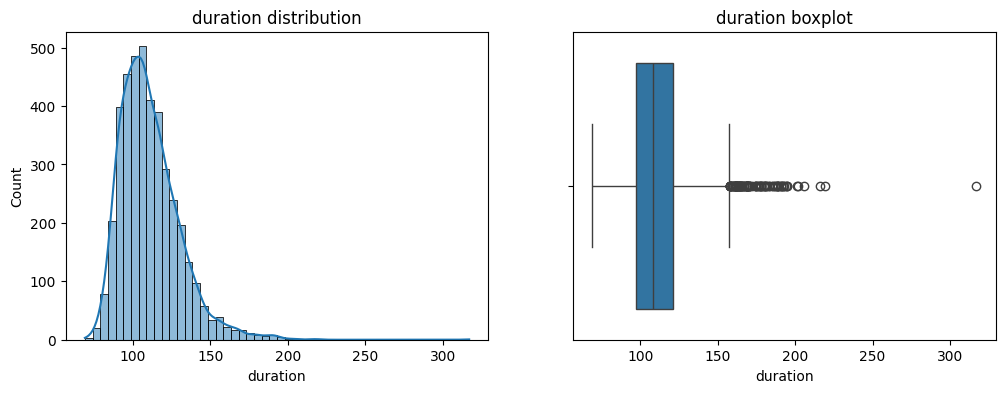

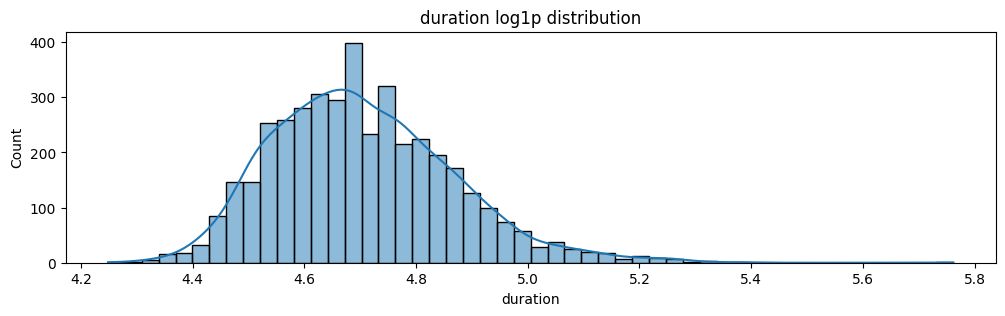

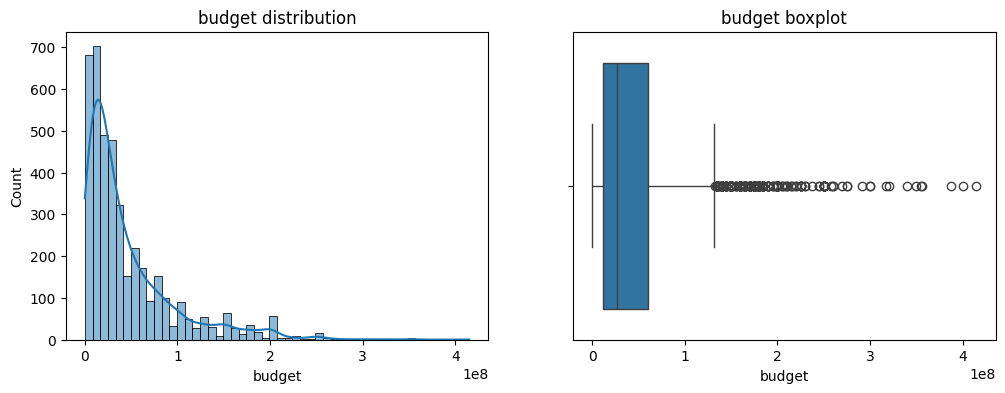

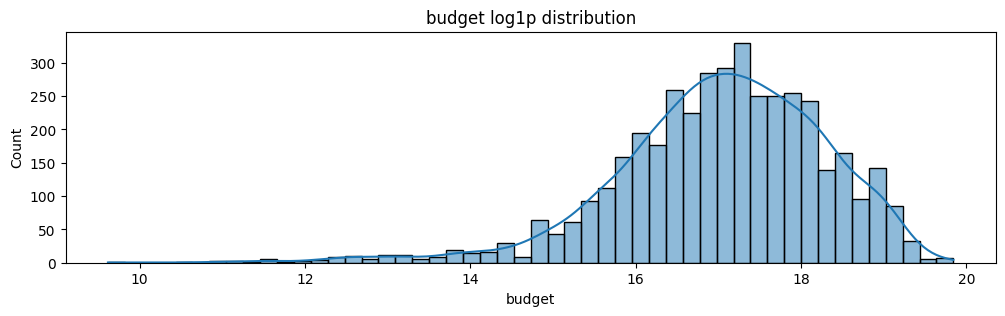

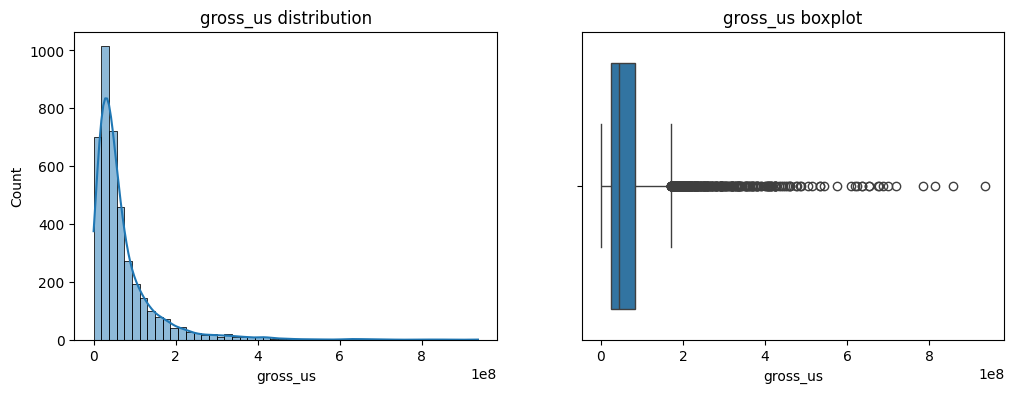

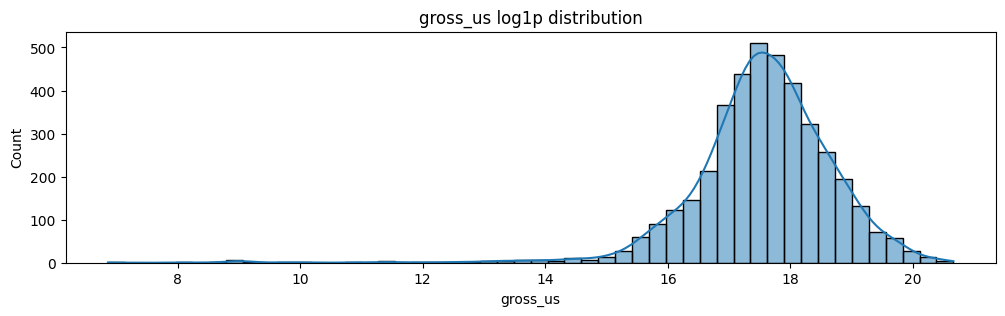

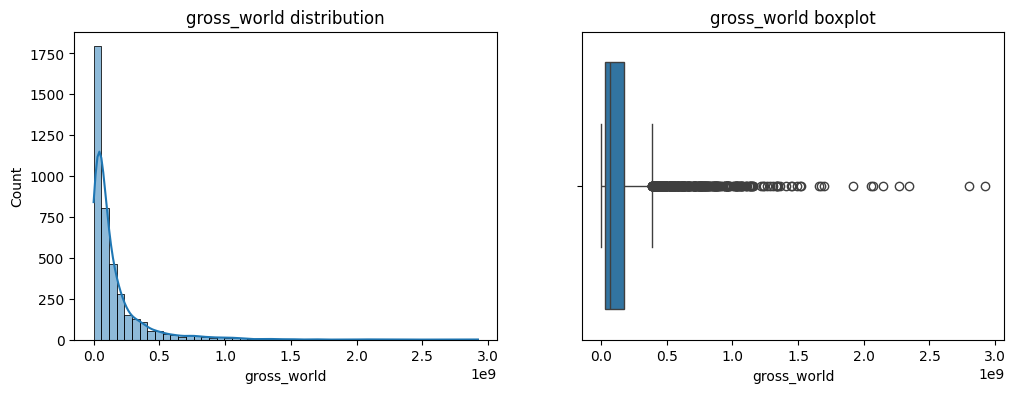

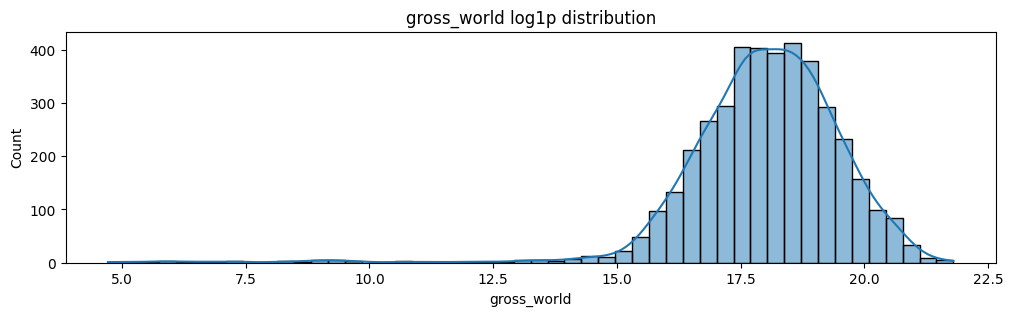

In [473]:
numeric_cols = ['duration','budget','gross_us','gross_world',]

def plot_distributions(df, cols=numeric_cols, log_plot=True):
    for col in cols:
        s = df[col].dropna()
        if s.empty:
            continue
        plt.figure(figsize=(12,4))
        plt.subplot(1,2,1)
        sns.histplot(s, bins=50, kde=True)
        plt.title(f'{col} distribution')
        plt.subplot(1,2,2)
        sns.boxplot(x=s)
        plt.title(f'{col} boxplot')
        plt.show()
        if log_plot:
            plt.figure(figsize=(12,3))
            sns.histplot(np.log1p(s), bins=50, kde=True)
            plt.title(f'{col} log1p distribution')
            plt.show()

plot_distributions(df, numeric_cols)

### 3.1.2. Когда выходят фильмы, пики перед праздниками.

(гистограмма месяцев)


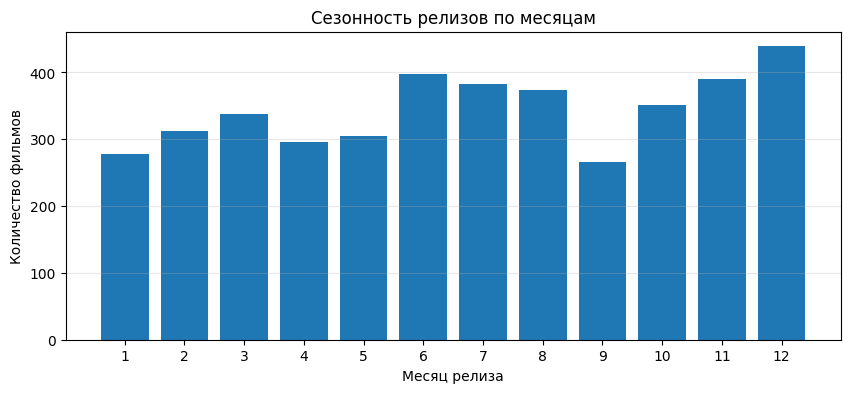

In [474]:
month_counts = df['release_month'].value_counts(dropna=True).sort_index()

plt.figure(figsize=(10, 4))
plt.bar(month_counts.index.astype(int), month_counts.values)
plt.title('Сезонность релизов по месяцам')
plt.xlabel('Месяц релиза')
plt.ylabel('Количество фильмов')
plt.xticks(range(1, 13))
plt.grid(True, axis='y', alpha=0.3)
plt.show()

### 3.1.3. Анализ жанров (топ жанров и распределение длительности по жанрам).


Самый частый жанр - Драма. Редкий - Вестерн.

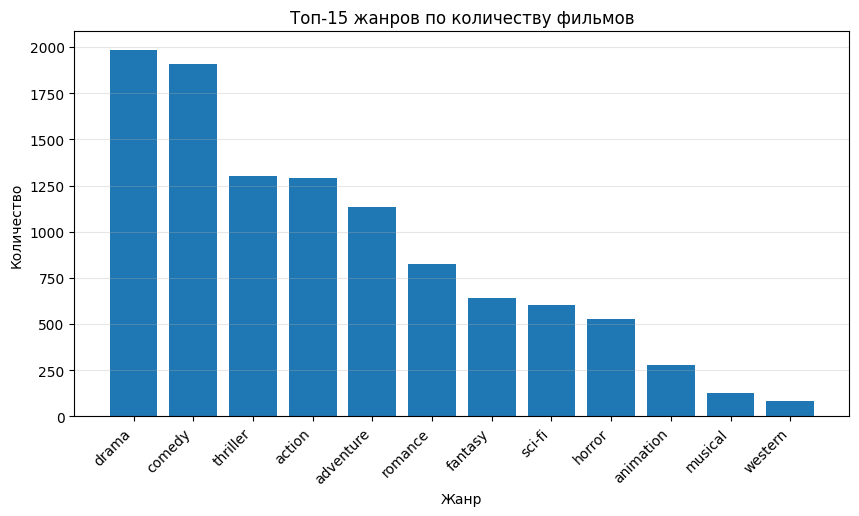

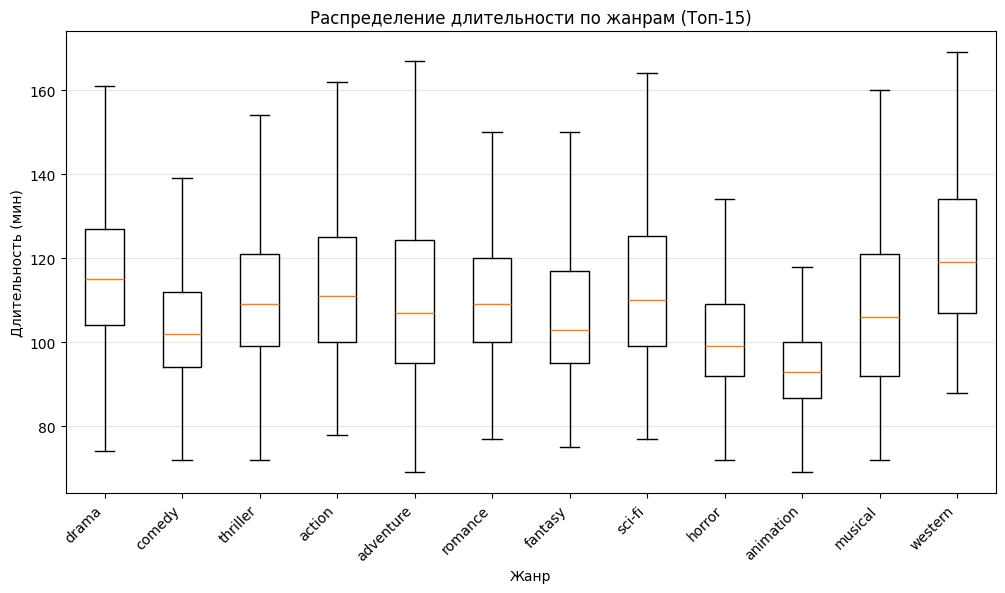

In [475]:

# Топ жанров
df_genre = df.explode('genre_base')
df_genre = df_genre[df_genre['genre_base'].notna() & (df_genre['genre_base'] != '')]

top_n = 15
top_genres = df_genre['genre_base'].value_counts().head(top_n)
plt.figure(figsize=(10, 5))
plt.bar(top_genres.index, top_genres.values)
plt.title(f'Tоп-{top_n} жанров по количеству фильмов')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

# Длительность по жанрам (boxplot)
# берём только tоп жанры
df_top = df_genre[df_genre['genre_base'].isin(top_genres.index)].dropna(subset=['duration'])

# маассивы длительностей по жанрам
groups = [df_top.loc[df_top['genre_base'] == g, 'duration'].values for g in top_genres.index]

plt.figure(figsize=(12, 6))
plt.boxplot(groups, labels=top_genres.index, showfliers=False)  # showfliers=True если хочешь видеть выбросы
plt.title(f'Распределение длительности по жанрам (Tоп-{top_n})')
plt.xlabel('Жанр')
plt.ylabel('Длительность (мин)')
plt.xticks(rotation=45, ha='right')
plt.grid(True, axis='y', alpha=0.3)
plt.show()

## 3.2. Бюджет → сборы → окупаемость.


### 3.2.1. Связь бюджета и мировых сборов.


- ось Х - Бюджет
- ось У - Мировые сборы
- Красная линия это линия "окупаемости", собрали больше чем потратили.

Мы видим что в среднем **чем больше бюджет тем больше мировые сборы**.

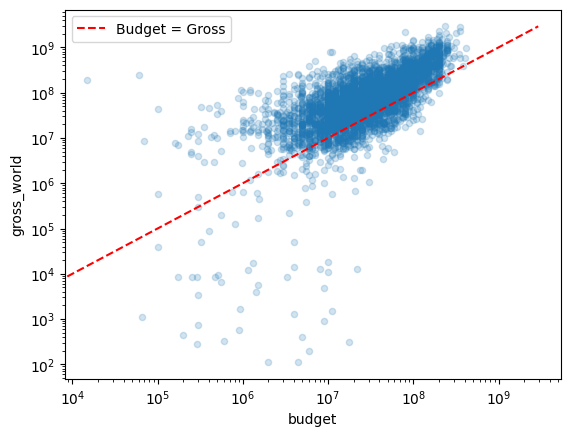

In [476]:
# 3.2.1
tf = df[(df["has_budget"]) & df["has_gross_world"]]
ax = tf.plot(x="budget",y="gross_world", logx=True, logy=True, alpha=0.2, kind="scatter")
# Линия окупаемости, не знаю если нужна, раз мы рассматриваем топ фильмов
maxMoney = max(tf['budget'].max(), tf['gross_world'].max())
ax.plot([0, maxMoney], [0, maxMoney], color="red", linestyle="--", label="Budget = Gross")
ax.legend()
plt.show()

plt.show()

### 3.2.2. Cвязь бюджета и возврата на инвестиции (ROI).

По графику ниже видно что есть небольшая тенденция более бюджетным фильмам окупаться на бОльший процент чем большИм. Но большинство фильмов имеет возврат инвестиций ниже 500%

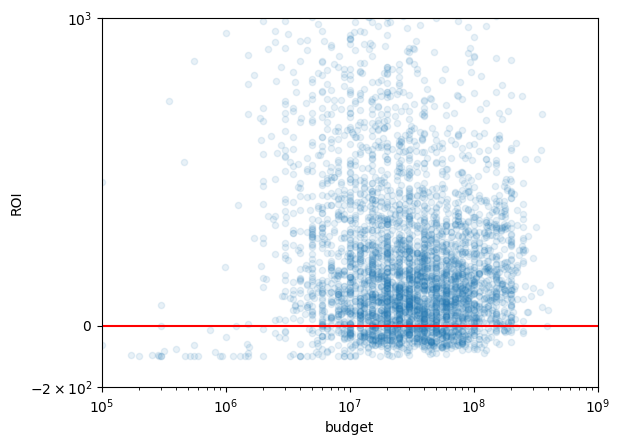

In [477]:
tfForScatter = tf#[(tf['ROI'] >= tf_q1 - 4.5*tf_iqr) & (tf['ROI'] <= tf_q3 + 4.5*tf_iqr)]
tfForScatter.plot(x="budget", y="ROI", logx=True, alpha=0.10, kind="scatter")

plt.axhline(0, color="red")
plt.yscale('symlog', linthresh=1000)
plt.ylim(bottom=-200)
# Зум
plt.ylim(top=1000)
plt.xlim(left=10**5)
plt.xlim(right=10**9)
plt.show()

### 3.2.3. Анализ ROI: топ-20 по ROI, ROI  по странам, жанры с высоким ROI.

#### 3.2.3.1 Топ 20 фильмов по окупаемости.

Видно что в топах по окупаемости много хорроров. "Ведьма из Блэр" и "Паранормальные явления" явные мега-хиты собрашвшие сотни миллионов долларов сборов при минимальном бюджете.


In [478]:

topRoi = df.sort_values(by="ROI", ascending=False).reset_index()
#top 20 roi
view = topRoi[['title', 'budget', 'gross_world', 'ROI', "rating", "genre_base"]].head(20)
view.style.format({
    'budget': '${:,.0f}',     
    'gross_world': '${:,.0f}',
    'ROI': '{:,.1f}%',
    'rating': '{:,.1f}'
})

,title,budget,gross_world,ROI,rating,genre_base
0,Paranormal Activity,"$15,000","$193,355,933","1,288,939.6%",6.3,['horror']
1,The Blair Witch Project,"$60,000","$248,639,881","414,299.8%",6.5,['horror']
2,The Gallows,"$100,000","$42,964,410","42,864.4%",4.3,"['horror', 'thriller']"
3,Halloween,"$325,000","$47,175,973","14,415.7%",7.7,"['horror', 'thriller']"
4,Good Boy,"$70,000","$8,676,112","12,294.4%",6.2,"['horror', 'thriller']"
5,Rocky,"$960,000","$117,253,345","12,113.9%",8.1,['drama']
6,Napoleon Dynamite,"$400,000","$46,141,106","11,435.3%",7.0,['comedy']
7,Open Water,"$500,000","$54,683,487","10,836.7%",5.8,"['drama', 'horror', 'thriller', 'adventure']"
8,The Devil Inside,"$1,000,000","$101,758,490","10,075.8%",4.2,['horror']
9,The Rocky Horror Picture Show,"$1,200,000","$116,574,698","9,614.6%",7.4,"['comedy', 'musical', 'horror']"


#### 3.2.3.2. Анализ бюджета по странам.


Взяв 10 стран где само много фильмов в нашем датасете мы можем посмотреть на средний возврат инвестиций фильмов. По графикам видно, что в США и не самая большая медиана, но очень много выбросов собравших большой возврат инвестиций, "хитов".

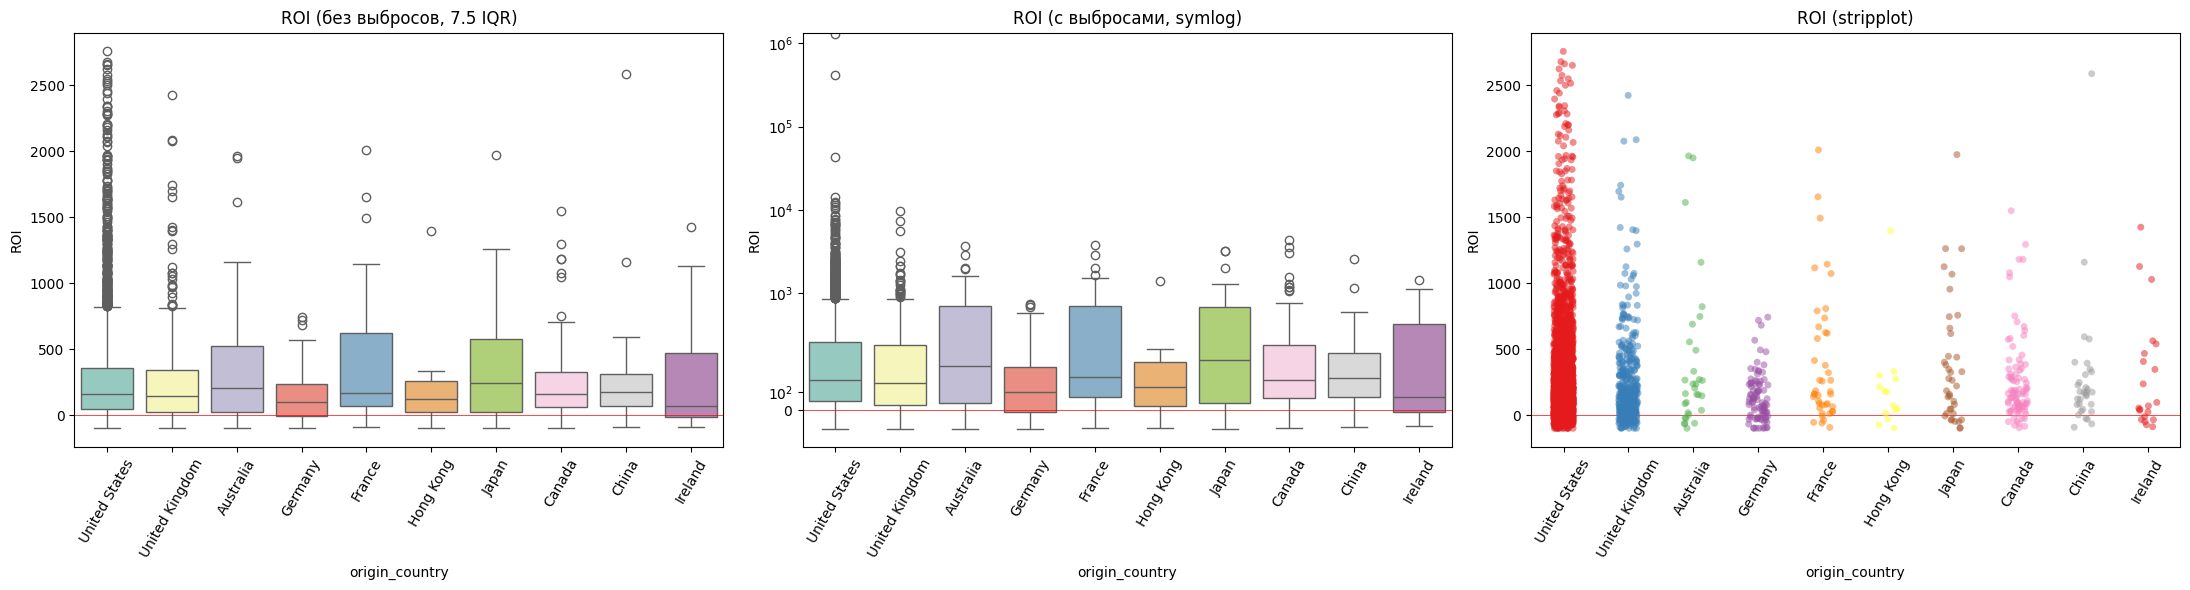

In [511]:
tf = df[(df["has_budget"]) & df["has_gross_world"]]
# фильмов с бюджетом < 10,000 всего один, если мы не уберем его в очистке позже
# print(tf[tf["budget"]<10000].count())

tf_q1 = tf['ROI'].quantile(0.25)
tf_q3 = tf['ROI'].quantile(0.75)
tf_iqr = tf_q3 - tf_q1

# Для читабельности оставим только страны где само много фильмов
bestCountries = tf['origin_country'].value_counts().head(10).index
tfBestCountries = tf[tf['origin_country'].isin(bestCountries)]

# Уберем выбросы методом iqr для читабельности графика, использовал 7.5iqr чтобы оставить как можно больше "хитов"
tbc_q1 = tfBestCountries['ROI'].quantile(0.25)
tbc_q3 = tfBestCountries['ROI'].quantile(0.75)
tbc_iqr = tbc_q3 - tbc_q1
tfForBoxplot = tfBestCountries[(tfBestCountries['ROI'] >= tbc_q1 - 7.5*tbc_iqr) & (tfBestCountries['ROI'] <= tbc_q3 + 7.5*tbc_iqr)]

#boxorder = tfForBoxplot.groupby("origin_country")["ROI"].median().sort_values(ascending=False).index


fig, axes = plt.subplots(1, 3, figsize=(22, 6), sharey=False)

# Построим график boxplot очистив выбросы с помощью 7.5 iqr
sns.boxplot(
    x='origin_country',
    y='ROI',
    data=tfForBoxplot,
    palette="Set3",
    ax=axes[0]
)
axes[0].axhline(0, color="red", linewidth=0.5)
axes[0].set_title("ROI (без выбросов, 7.5 IQR)")
axes[0].tick_params(axis='x', rotation=60)

# Построим график boxplot с выбросами и симлог скейлом
sns.boxplot(
    x='origin_country',
    y='ROI',
    data=tfBestCountries,
    palette="Set3",
    ax=axes[1]
)
axes[1].axhline(0, color="red", linewidth=0.5)
axes[1].set_yscale('symlog', linthresh=500)
axes[1].set_ylim(bottom=-200)
axes[1].set_title("ROI (с выбросами, symlog)")
axes[1].tick_params(axis='x', rotation=60)

# Построим график stripplot
sns.stripplot(
    data=tfForBoxplot,
    x='origin_country',
    y='ROI',
    palette="Set1",
    jitter=0.15,
    alpha=0.5,
    ax=axes[2]
)
axes[2].axhline(0, color="red", linewidth=0.5)
axes[2].set_title("ROI (stripplot)")
axes[2].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

#### 3.2.3.3 Возврат инвестиций по жанрам.


По графику видно что хорроры неоспариваемый победитель в возврате инвестиций. Интересно заметить что хоть медианный бюджет анимаций в 5 раз больше чем у хорроров они все равно стоят на втором месте по медианном возврате инвестиций.

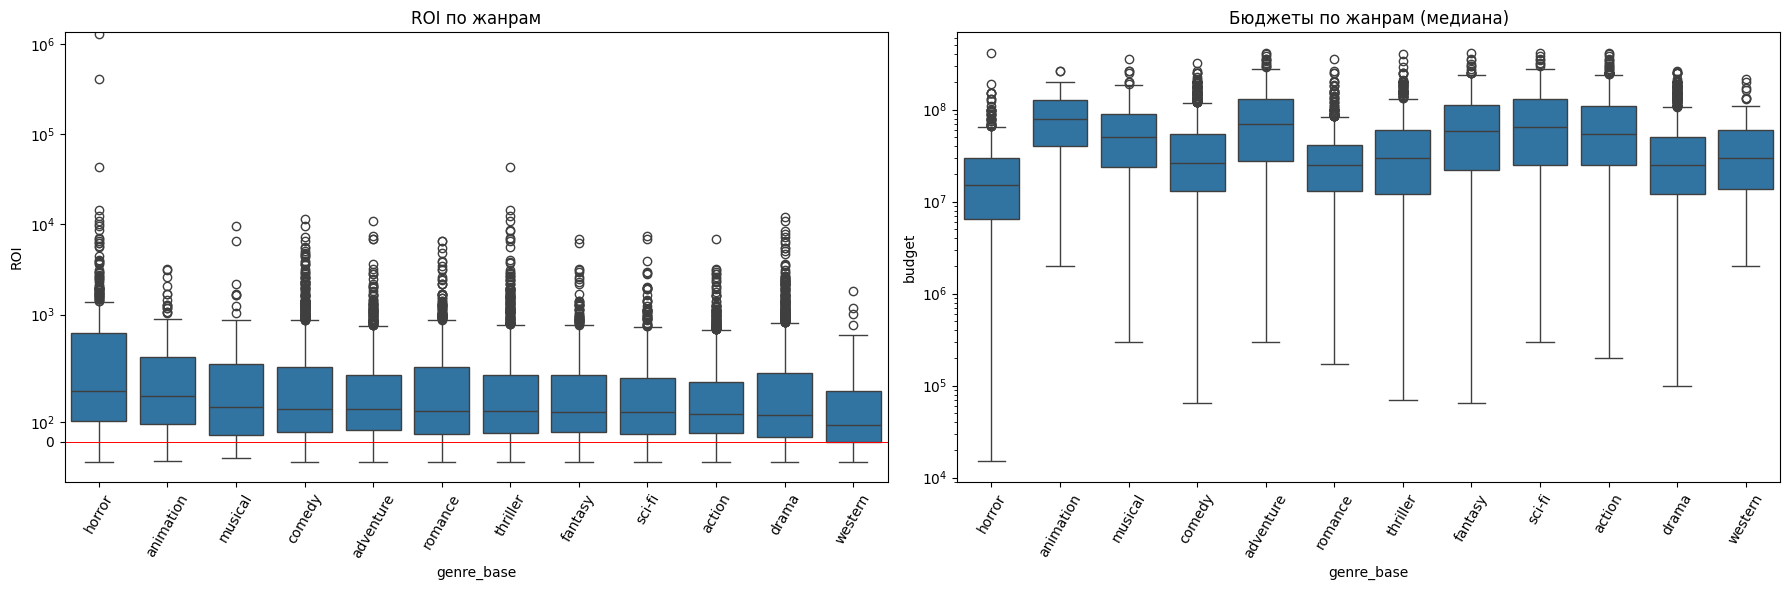

animation median budget 79000000.0 vs horror median budget 15000000.0


In [480]:
import ast
tf = df[(df["has_budget"]) & df["has_gross_world"]].copy()
# Превратим список жанров из строки в список
tf['genre_base'] = tf['genre_base'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

#Использую симлог вместо убирания выбросов #уберем выбросы 6 iqr чтобы оставить как можно больше хитов
tfForBoxplot = tf # [(tf['ROI'] >= tf_q1 - 6*tf_iqr) & (tfBestCountries['ROI'] <= tf_q3 + 6*tf_iqr)]

# чтобы жанр учавствовал во всех своих подсчетах разделим genre base на несколько строк: по строке на жанр
tf_exploded = tfForBoxplot.explode("genre_base").reset_index()
#print(tf_exploded.shape, tf.shape)
#print(tf_exploded.head(5))

# Отсортируем по медианам
roi_genres = tf_exploded.groupby('genre_base')['ROI'].median().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(18, 6), sharex=True)

roi_genres = tf_exploded.groupby('genre_base')['ROI'].median().sort_values(ascending=False)
sns.boxplot(
    data=tf_exploded,
    x="genre_base",
    y="ROI",
    order=roi_genres.index,
    ax=axes[0]
)
axes[0].axhline(0, color="red", linewidth=0.7)
axes[0].set_yscale('symlog', linthresh=500)
axes[0].set_ylim(bottom=-200)
axes[0].set_title("ROI по жанрам")
axes[0].tick_params(axis='x', rotation=60)

budget_genres = tf_exploded.groupby('genre_base')['budget'].median().sort_values(ascending=False)
sns.boxplot(
    data=tf_exploded,
    x="genre_base",
    y="budget",
    order=roi_genres.index,
    ax=axes[1]
)
axes[1].set_yscale("log")
axes[1].set_title("Бюджеты по жанрам (медиана)")
axes[1].tick_params(axis='x', rotation=60)

plt.tight_layout()
plt.show()

print(f"animation median budget {budget_genres['animation']} vs horror median budget {budget_genres['horror']}")

## 3.3. Жанры и успех.


### 3.3.1. Рейтинг по жанрам.


Медианный рейтинг драм самый большой, на втором месте - анимации. Ниже приведена быстрая сводка по медианным значениям.
- Драмы: низкий возврат инвестиций, большой рейтинг, средний бюджет на более низкой стороне
- Хорроры: высокий возврат инвестций, низкий рейтинг, низкий бюджет
- Анимационные фильмы: высокий возврат инвестиций, высокий рейтинг, высокий бюджет.

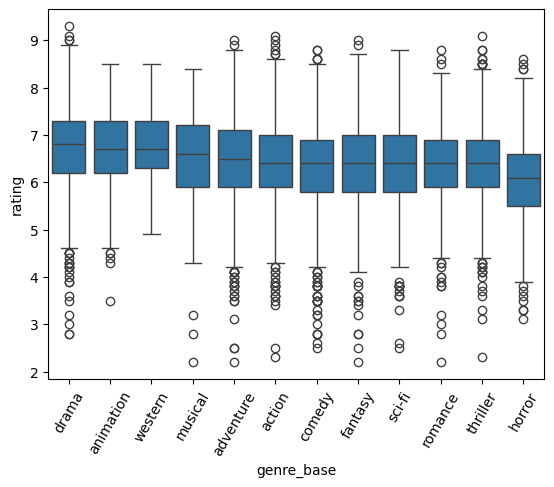

In [512]:
#4
tf_exploded = tf.explode("genre_base").reset_index()

rating_genres = tf_exploded.groupby('genre_base')['rating'].median().sort_values(ascending=False)

# Рейтинг по жанрам
sns.boxplot(data=tf_exploded, x="genre_base", y="rating", order=rating_genres.index)
plt.xticks(rotation=60)
plt.show()

### 3.3.2. Медианные значения статистик по жанрам.

In [513]:
genreStats = tf_exploded.groupby('genre_base').agg({
    'ROI': 'median',
    'rating': 'median',
    'budget': 'median'
})

view = genreStats.sort_values(["ROI", "rating", "budget"], ascending=False).reset_index()[['genre_base', 'ROI', 'rating', 'budget']]
view.style.format({
    'budget': '${:,.0f}',
    'ROI': '{:,.1f}%',
    'rating': '{:,.1f}'
})


,genre_base,ROI,rating,budget
0,horror,255.0%,6.1,"$15,000,000"
1,animation,230.1%,6.7,"$79,000,000"
2,musical,172.0%,6.6,"$50,000,000"
3,comedy,166.4%,6.4,"$26,000,000"
4,adventure,165.7%,6.5,"$70,000,000"
5,romance,154.5%,6.4,"$25,000,000"
6,thriller,154.1%,6.4,"$30,000,000"
7,fantasy,151.0%,6.4,"$58,000,000"
8,sci-fi,148.8%,6.4,"$65,000,000"
9,action,138.2%,6.4,"$55,000,000"


### 3.3.3. Наглядный график возврата инвестиций и рейтинга от жанров.


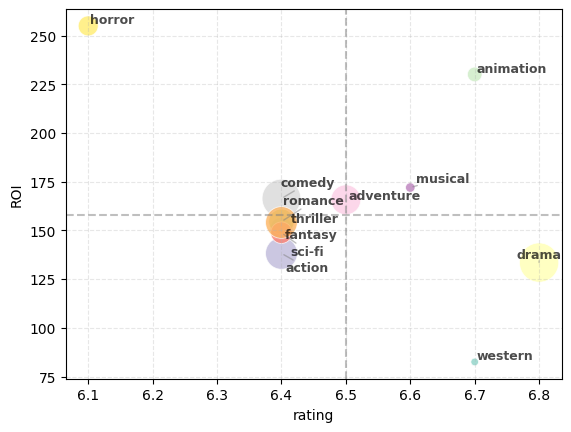

In [484]:
#%pip install adjustText
from adjustText import adjust_text

genreStats = tf_exploded.rename(columns={'budget': 'count'}).groupby('genre_base').agg({
    'ROI': 'median',
    'rating': 'median',
    'count': 'count'
})

# берем только статистику где достаточное количество фильмов чтобы ее составить
count_thresh = 50
genreStats = genreStats[genreStats["count"] > count_thresh]

sns.scatterplot(
    data=genreStats,
    x='rating',
    y='ROI',
    size='count',
    sizes=(30, 800),
    hue="ROI",
    palette="Set3",
    alpha=0.8,
    legend=False
)

texts = []
i = 0
for genre in genreStats.index:
    x = genreStats.loc[genre, 'rating']
    y = genreStats.loc[genre, 'ROI']
    texts.append(plt.text(x, y, genre, fontsize=9, fontweight='bold', alpha=0.7))
    i += 1
adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))

# Линии-разделители (средние по рынку)
avg_rating = tf_exploded['rating'].median()
avg_roi = tf_exploded['ROI'].median()

plt.axvline(avg_rating, color='gray', linestyle='--', alpha=0.5, label=f'Median Rating ({avg_rating})')
plt.axhline(avg_roi, color='gray', linestyle='--', alpha=0.5, label=f'Median ROI ({avg_roi:.1f}%)')
plt.grid(True, linestyle='--', alpha=0.3)

plt.show()

### 3.3.4. Фильмы провалившиеся в прокате но занявшие места в сердце зрителей.


Далее идет список топ 10% фильмов по рейтингу у которых негативный возврат инвестиций. Можно заметить хоть у анимаций хороший медианный возврат инвестиций в этом списке в топе именно анимации с большими бюджетами.

In [485]:
# Quantile 0.9 rating, negative ROI
rating_thresh = df["rating"].quantile(0.9)
goodRatedFlops = df[(df["ROI"] < 0) & (df["rating"] > rating_thresh)]
goodRatedFlops = goodRatedFlops.sort_values("rating", ascending=False).reset_index()
view = goodRatedFlops[['title', 'budget', 'ROI', "rating"]]
view.style.format({
    'budget': '${:,.0f}',
    'ROI': '{:,.1f}%',
    'rating': '{:,.1f}'
})
# Топ 10% фильмов по рейтингу которые не окупились

,title,budget,ROI,rating
0,Das Boot,"$14,255,802",-19.4%,8.4
1,Dersu Uzala,"$4,000,000",-99.6%,8.2
2,The Iron Giant,"$70,000,000",-66.7%,8.1
3,Barry Lyndon,"$11,000,000",-94.8%,8.1
4,Soul,"$150,000,000",-18.7%,8.0
5,Stalker,"$1,552,795",-70.6%,8.0
6,Almost Famous,"$60,000,000",-21.0%,7.9
7,Mirror,"$820,580",-84.6%,7.9
8,Kagemusha: The Shadow Warrior,"$6,000,000",-33.0%,7.9
9,Children of Men,"$76,000,000",-7.1%,7.9


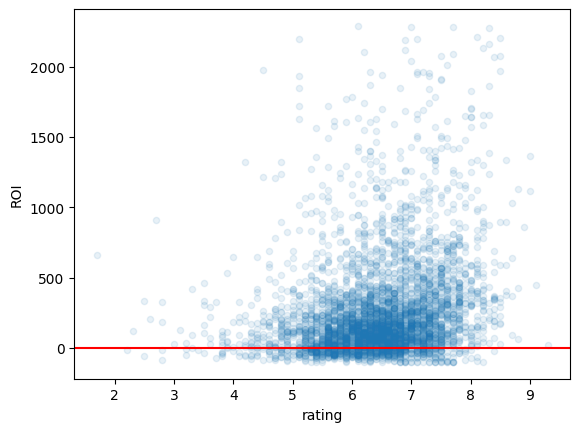

In [486]:
# Scatterplot budget vs ROI
tfForScatter = tf[(tf['ROI'] >= tf_q1 - 6*tf_iqr) & (tf['ROI'] <= tf_q3 + 6*tf_iqr)]
tfForScatter.plot(x="rating", y="ROI", logx=False, alpha=0.1, kind="scatter")
plt.axhline(0, color="red")
plt.show()

### 3.3.5. Но есть ли тренд между рейтингом и сборами?


По графику ниже, где красным идет линия тренда можно явно увидеть что более высокие рейтинги, как правило, имеют более большой возврат инвестиций. Что конечно не отрицает существование фильмов с хорошими рейтингами но негативными возвратами инвестиций

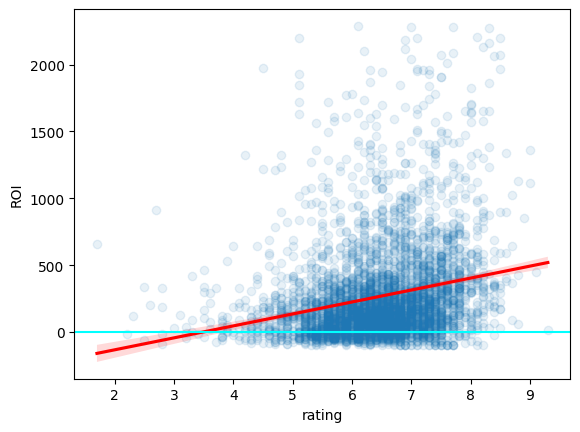

In [487]:
#Тоже самое что выше но линия тренда с помощью СНС, не знаю можно ли ее использовать ведь мы сами не считали тренд, зато наглядно
sns.regplot(
    data=tfForScatter, 
    x="rating", 
    y="ROI", 
    scatter_kws={'alpha': 0.1}, 
    line_kws={'color': 'red'}
)
plt.axhline(0, color="cyan")
plt.show()

### 3.3.6. Жанры по странам. Какой жанр чаще снимают в определенной стране?


По графику ниже видно что в Японии анимации в процентном соотношении снимают чаще чем в других странах. В США само часто снимают драмы и комедии.
А из Франции выходит много триллеров.

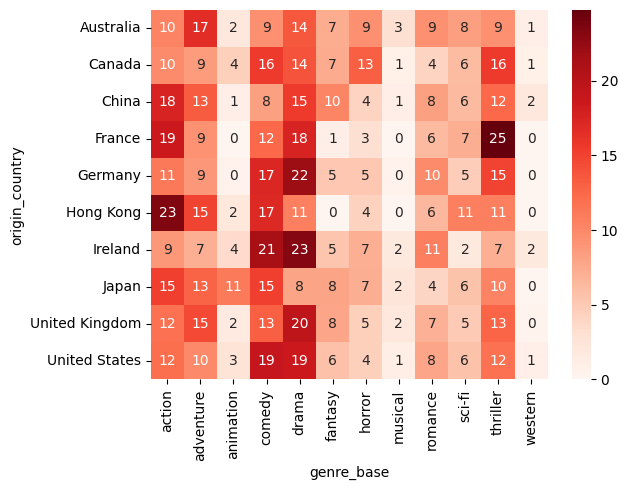

In [488]:
tf_exploded = tf.explode("genre_base")
# Для читабельности оставим только страны где само много фильмов
bestCountries = tf_exploded['origin_country'].value_counts().head(10).index
tf_exploded = tf_exploded[tf_exploded['origin_country'].isin(bestCountries)]

# Видно проблему, у нас выборка почти полностью из США, посчитаю процентно
# pt = pd.crosstab(tf_exploded['origin_country'], tf_exploded['genre_base'])
# sns.heatmap(
#     pt, 
#     annot=True,
#     fmt='d',
# )

pt_normalized = pd.crosstab(
    tf_exploded['origin_country'], 
    tf_exploded['genre_base'], 
    normalize='index'
)

sns.heatmap(
    pt_normalized * 100, 
    annot=True, 
    fmt='.0f',
    cmap='Reds',
)

plt.show()

## 3.4. Комбинации жанров и выводы о них.

### 3.4.1. Графики жанров и комбинации двух жанров вместе.

Создадим комбинации из 2х жанров и проведем анализ по ROI и рейтингу

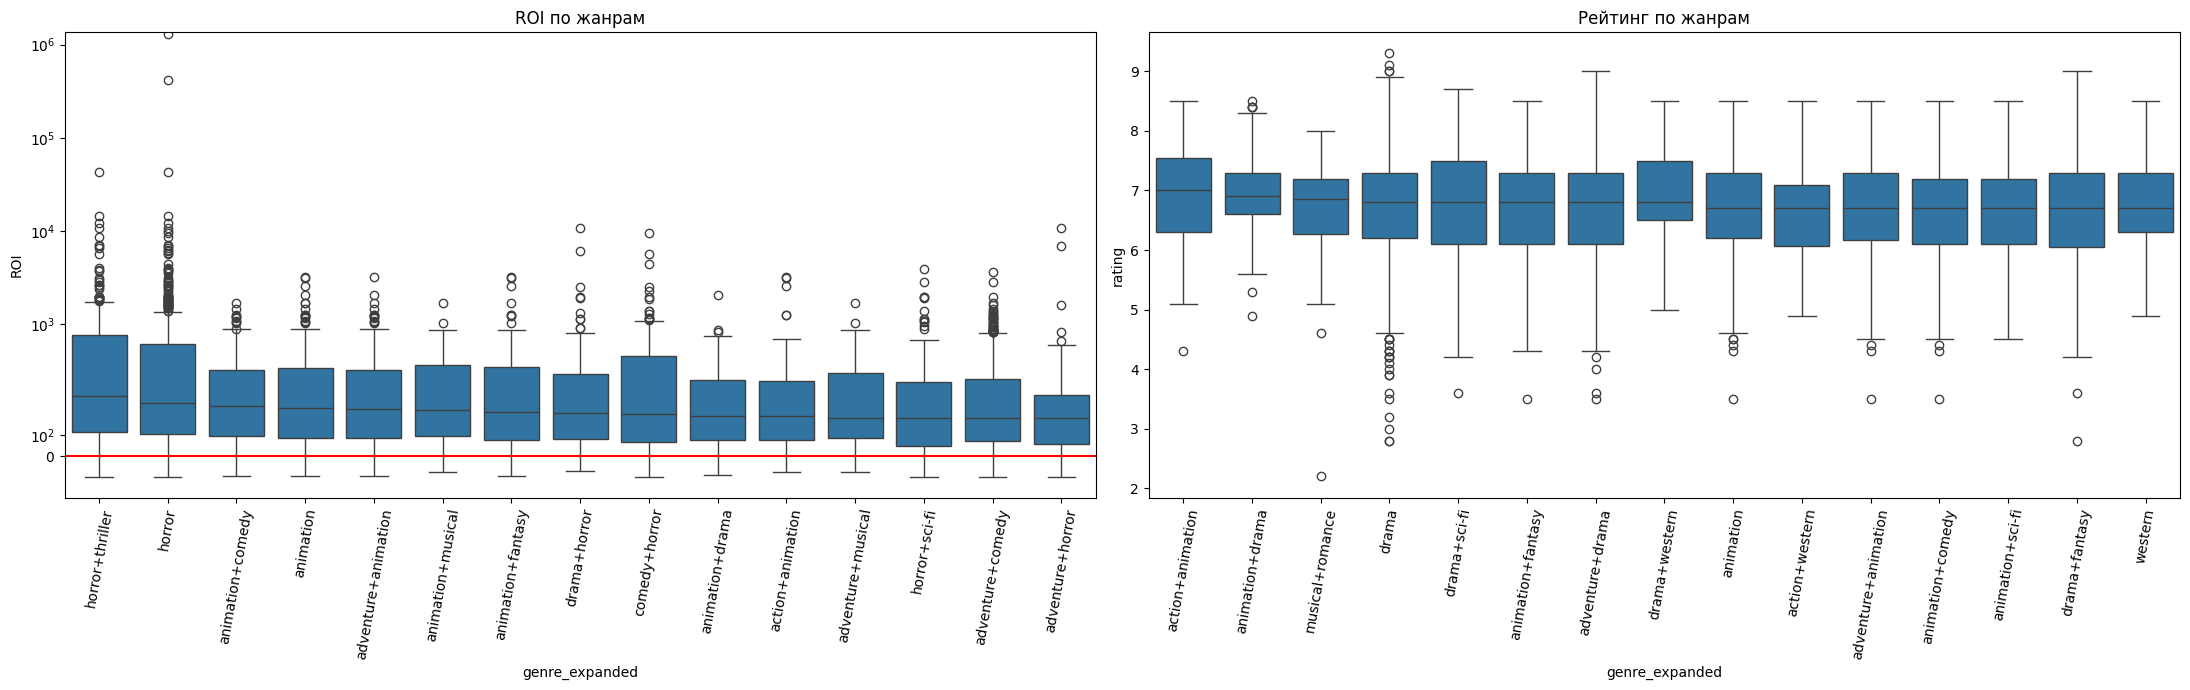

In [489]:
base_genres = ['comedy','musical', 'drama', 'horror', 
               'action', 'romance', 'sci-fi', 'thriller', 
               'documentary','adventure', 'animation', 'fantasy', 
               'western']


def add_genre_combo(x):
    x.sort()
    new_list = []
    for g1 in x:
        for g2 in x:
            if (g1 != g2 and f"{g2}+{g1}" not in new_list):
                new_list.append(f"{g1}+{g2}")
    new_list += x
    return new_list

tf["genre_expanded"] = tf["genre_base"].apply(add_genre_combo)

tf_exploded = tf.explode("genre_expanded").reset_index()

# Возьмем только те где достаточное количество жанров
count_thresh = 30
genreComboCount = tf_exploded["genre_expanded"].value_counts()
genreComboCount = genreComboCount[genreComboCount > count_thresh]
tf_exploded = tf_exploded[tf_exploded["genre_expanded"].isin(genreComboCount.index)]

#Возьмем 15 лучших комбинаций и жанров по РОИ
num_genres = 15
tf_exploded_best_roi = tf_exploded.groupby('genre_expanded')["ROI"].median().sort_values(ascending=False).head(num_genres).index

exploded_roi = tf_exploded[tf_exploded["genre_expanded"].isin(tf_exploded_best_roi)]

# Отсортируем по медианам
roi_genres = exploded_roi.groupby('genre_expanded')['ROI'].median().sort_values(ascending=False)


#Возьмем 15 лучших комбинаций и жанров по рейтингу
num_genres = 15
tf_exploded_best_genre = tf_exploded.groupby('genre_expanded')["rating"].median().sort_values(ascending=False).head(num_genres).index

exploded_rating = tf_exploded[tf_exploded["genre_expanded"].isin(tf_exploded_best_genre)]

rating_genres = exploded_rating.groupby('genre_expanded')['rating'].median().sort_values(ascending=False)


fig, axes = plt.subplots(1, 2, figsize=(22, 7), sharex=False)
# ROI по жанрам
sns.boxplot(
    data=exploded_roi,
    x="genre_expanded",
    y="ROI",
    order=roi_genres.index,
    ax=axes[0]
)
axes[0].tick_params(axis='x', rotation=80)
axes[0].axhline(0, color="red")
axes[0].set_yscale('symlog', linthresh=500)
axes[0].set_ylim(bottom=-200)
axes[0].set_title("ROI по жанрам")

# Рейтинг по жанрам
sns.boxplot(
    data=tf_exploded,
    x="genre_expanded",
    y="rating",
    order=rating_genres.index,
    ax=axes[1]
)
axes[1].tick_params(axis='x', rotation=80)
axes[1].set_title("Рейтинг по жанрам")

plt.tight_layout()
plt.show()


### 3.4.2. Синергии жанров по рейтингу и по возврату инвестиций.
Построив хитмап и сравнив значения с медианными мы можем найти какие жанры работают само хорошо друг с другом.
Как читать дельта графики: Идет разница медианы значения комбинации жанров и медианы значения жанра по оси Х

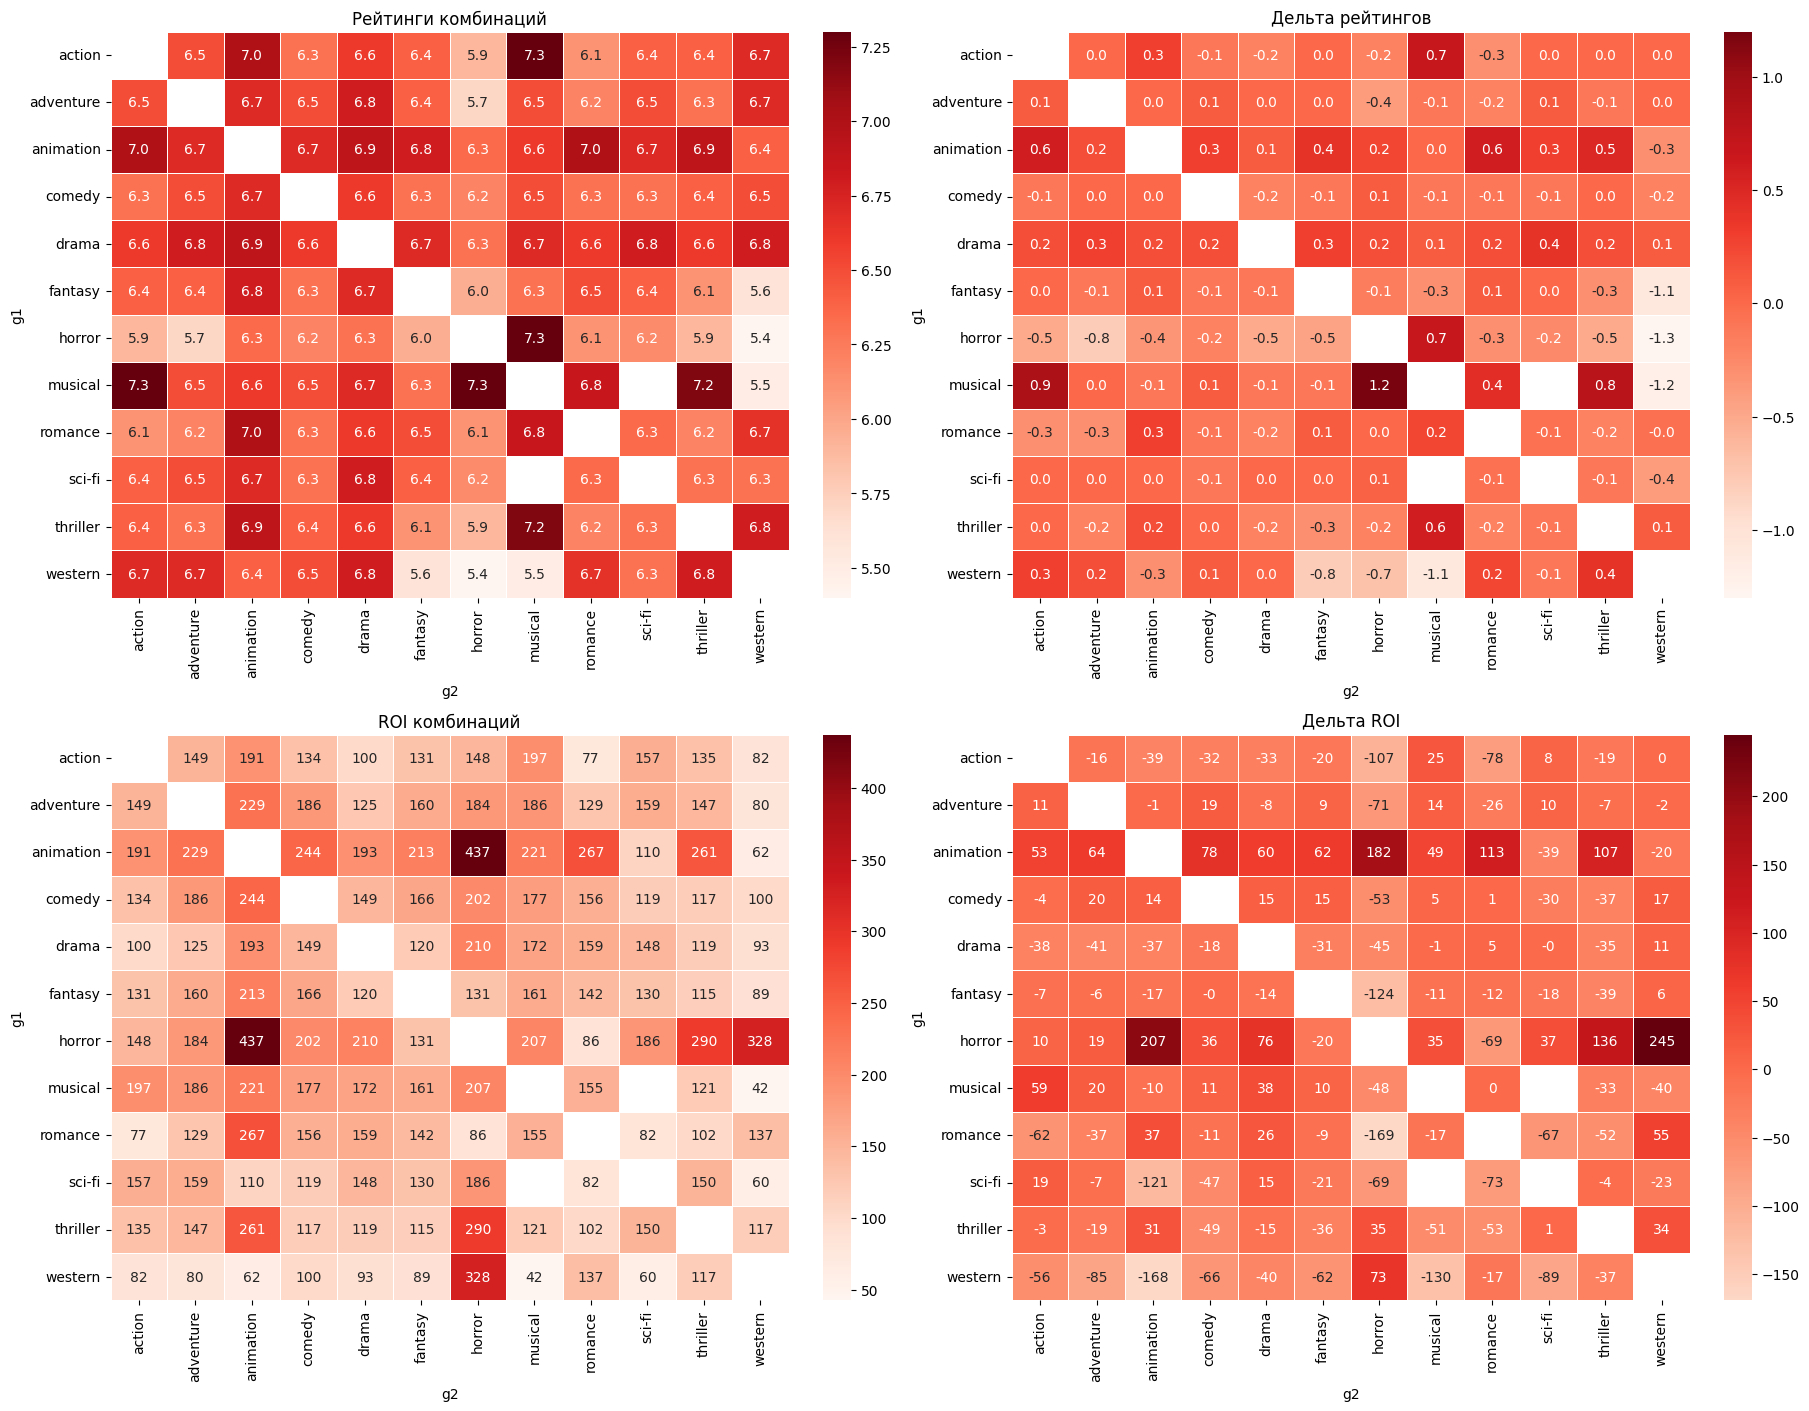

In [490]:
tf_exploded = tf.explode("genre_base").reset_index()

new_data = pd.DataFrame()
tmp_data = []
for index, row in tf.iterrows():
    x = sorted(row["genre_base"])
    for g1 in x:
        for g2 in x:
            if (g1 != g2):
                tmp_data.append({'g1': g1, 'g2': g2, 'ROI': row['ROI'], 'rating': row['rating']})

df_gcombos = pd.DataFrame(tmp_data)

# RATING
# Медианный рейтинг комбинаций
pt_rating = pd.crosstab(
    df_gcombos['g1'],
    df_gcombos['g2'],
    values=df_gcombos["rating"],
    aggfunc="median"
)

median_g2_rating = tf_exploded.groupby("genre_base")['rating'].median()
delta_rating = pt_rating.sub(median_g2_rating, axis=1)

# ROI
# Медианный ROI комбинаций
pt_roi = pd.crosstab(
    df_gcombos['g1'],
    df_gcombos['g2'],
    values=df_gcombos["ROI"],
    aggfunc="median"
)

median_g2_roi = tf_exploded.groupby("genre_base")['ROI'].median()
delta_roi = pt_roi.sub(median_g2_roi, axis=1)



fig, axes = plt.subplots(2, 2, figsize=(18, 14), constrained_layout=True)

# 1. Рейтинги комбинаций
sns.heatmap(
    pt_rating,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    linewidth=0.5,
    ax=axes[0, 0]
)
axes[0, 0].set_title("Рейтинги комбинаций")
axes[0, 0].set_xlabel("g2")
axes[0, 0].set_ylabel("g1")

# 2. Дельта рейтингов
sns.heatmap(
    delta_rating,
    annot=True,
    fmt=".1f",
    cmap="Reds",
    linewidth=0.5,
    center=0,            # важный смысловой штрих: 0 = без эффекта
    ax=axes[0, 1]
)
axes[0, 1].set_title("Дельта рейтингов")
axes[0, 1].set_xlabel("g2")
axes[0, 1].set_ylabel("g1")

# 3 Рейтинги комбинаций
sns.heatmap(
    pt_roi,
    annot=True,
    fmt=".0f",
    cmap="Reds",
    linewidth=0.5,
    ax=axes[1, 0]
)
axes[1, 0].set_title("ROI комбинаций")
axes[1, 0].set_xlabel("g2")
axes[1, 0].set_ylabel("g1")

# 4. Дельта рейтингов
sns.heatmap(
    delta_roi,
    annot=True,
    fmt=".0f",
    cmap="Reds",
    linewidth=0.5,
    center=0,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Дельта ROI")
axes[1, 1].set_xlabel("g2")
axes[1, 1].set_ylabel("g1")

plt.show()


#sanity check проверка вручную пары значений
# median_comedy = tf_exploded[tf_exploded["genre_base"] == "comedy"]["ROI"].median()
# median_drama_comedy = df_gcombos[(df_gcombos["g1"] == "drama") & (df_gcombos["g2"] == "comedy")]["ROI"].median()
# print(median_drama_comedy - median_comedy)

# median_drama = tf_exploded[tf_exploded["genre_base"] == "drama"]["ROI"].median()
# median_comedy_drama = df_gcombos[(df_gcombos["g1"] == "comedy") & (df_gcombos["g2"] == "drama")]["ROI"].median()
# print(median_comedy_drama - median_drama)

---

## 3.5. Собственная метрика успеха.


In [491]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder # применяем для нормирования признаков
df.head(3)

,year,place,title,rating,duration,director,genre,release_date,origin_country,company,...,open_week,budget_currency,budget,release_month,genre_base,has_budget,has_gross_us,has_gross_world,has_open_week,ROI
0,1975,1,Jaws,8.1,124,Steven Spielberg,"['Disaster', 'Monster Horror', 'Sea Adventure'...",1975-06-20,United States,Zanuck/Brown Productions,...,7061513,$,7000000.0,6,"[adventure, horror, thriller]",True,True,True,True,6910.518571
1,1975,2,The Rocky Horror Picture Show,7.4,100,Jim Sharman,"['B-Horror', 'Dark Comedy', 'Parody', 'Raunchy...",1975-09-29,United Kingdom,Twentieth Century Fox,...,135000,$,1200000.0,9,"[comedy, horror, musical]",True,True,True,True,9614.558167
2,1975,3,One Flew Over the Cuckoo's Nest,8.6,133,Milos Forman,"['Dark Comedy', 'Medical Drama', 'Psychologica...",1975-11-21,United States,Fantasy Films,...,<NA>,$,3000000.0,11,"[comedy, drama]",True,True,True,False,3537.660233


Создадим метрику успеха. Для начала рассмотрим основные парамерты, которые можно будет включить в финальную формулу. 

- ROI
- Сборы
- Длительность фильма
- Рейтинг
- Сезон выхода

А так же проверим как выбранные параметры коррелируют между собой, чтобы финальная метрика не были искажена.

In [492]:
df_4corr = df.dropna(subset=['rating', 'gross_world', 'ROI'])
df_4corr['gross_world_log'] = df_4corr['gross_world'].apply(lambda x: np.log10(x) if x > 0 else 0)

In [493]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df_4corr['season'] = df_4corr['release_month'].apply(get_season)
df_4corr['season_encoder'] = LabelEncoder().fit_transform(df_4corr['season'])

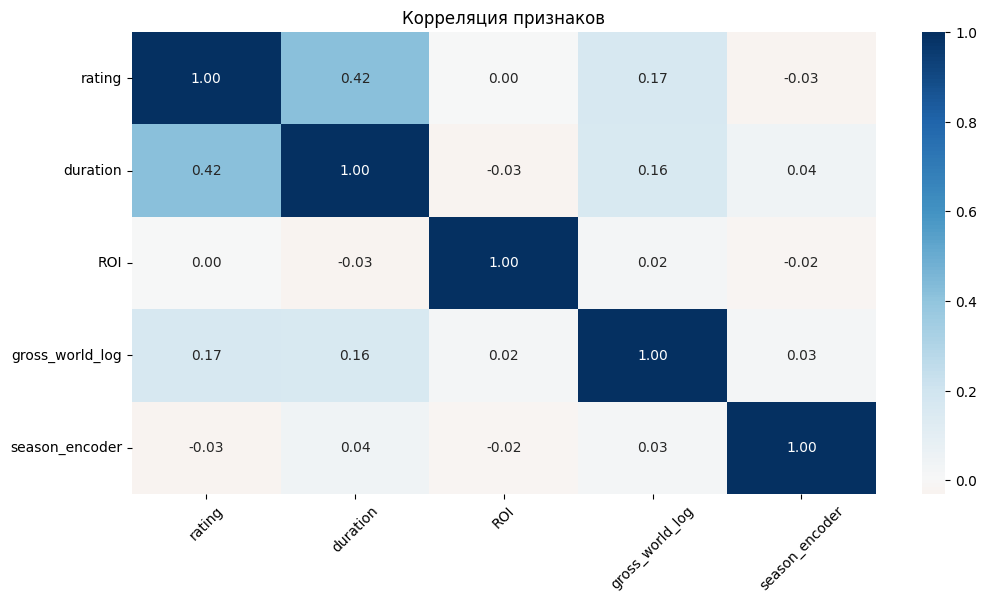

In [494]:
cols = ['rating', 'duration', 'ROI', 'gross_world_log', 'season_encoder']

df_corr = df_4corr[cols].corr()

# corr.map(lambda x: f'{x:.2f}')

plt.figure(figsize=(12, 6))

sns.heatmap(
    df_corr,
    annot=True,
    fmt='.2f',
    cmap='RdBu',
    center=0
)

plt.title('Корреляция признаков')         
plt.xticks(rotation=45)
plt.show()

Выбранные признаки слабо коррелируют друг с другом, кроме рейтинга и длительности (умеренная прямая корреляция, рассмотрим отдельно). Значит, признаки не дублируют друг друга, и в формуле успеха каждый фактор добавит свое значение. Сезон нет смысла добавлять, тк он не влияет на итоговый успех фильма. 

In [495]:
fig = px.scatter(
    df_4corr,
    x='rating',
    y='duration',
    color = 'year',
    opacity=0.6,
    title='Корреляция рейтинга и длительности фильма',
    labels={'duration': 'Длительность фильма', 'rating': 'Рейтинг фильма', 'year': 'Год'},
    width=1100,
    height=600
)

fig.show()

#### **Зададим формулу успеха**

$$
\text{success\_score} = 0.35*\text{rating\_norm} + 0.35*\text{gross\_world\_norm} + 0.20 *\text{ROI\_norm} + 0.10 *\text{duration\_norm}
$$


In [496]:
# нормализация 
def minmax_norm(x):
    return (x - x.min()) / (x.max() - x.min())

df_4corr['rating_norm'] = minmax_norm(df_4corr['rating'])
df_4corr['duration_norm'] = minmax_norm(df_4corr['duration'])
df_4corr['ROI_norm'] = minmax_norm(df_4corr['ROI'])
df_4corr['gross_world_norm'] = minmax_norm(df_4corr['gross_world_log'])

# метрика успеха
df_4corr['success_score'] = (0.35 * df_4corr['rating_norm'] +
                             0.35 * df_4corr['gross_world_norm'] +
                             0.20 * df_4corr['ROI_norm'] +
                             0.10 * df_4corr['duration_norm'])

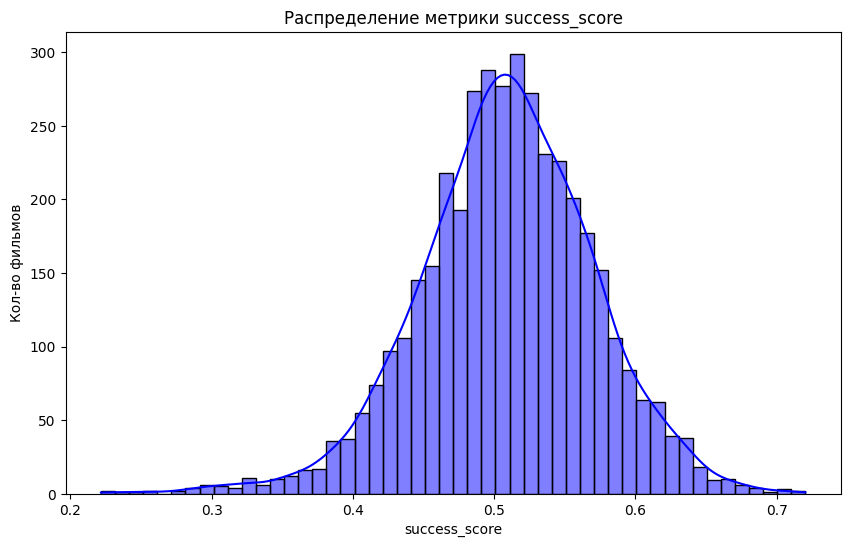

In [497]:
plt.figure(figsize=(10,6))

sns.histplot(df_4corr['success_score'],
         bins=50,
         color='blue',
         edgecolor='black',
         kde=True)
plt.title('Распределение метрики success_score')
plt.xlabel('success_score')
plt.ylabel('Кол-во фильмов')
plt.show()

In [498]:
top20 = df_4corr.sort_values('success_score', ascending=False).head(20)

fig = px.bar(
    top20,
    x='success_score',
    y='title',
    color='success_score',
    color_continuous_scale='Viridis',
    text='success_score',
    title='Топ-20 фильмов по success_score',
    height=600,
    width=1000
)

fig.update_layout(
    xaxis_title='',
    yaxis_title='',
    yaxis=dict(autorange='reversed'), 
    coloraxis_showscale=False
)
fig.update_traces(texttemplate='%{text:.2f}', textposition='inside')
fig.show()

#### Таким образом, самый успешный фильм по нашей **метрике успеха** - "Властелин колец: Возвращение короля". Оскар 2004 года это подтверждает (11 наград в 11 номинациях!). 

## 3.6. Самый успешный год в истории кино.

Сгруппируем по году (средние: success_score, rating, roi, gross_world) и выявим самый успешный год в кино, какие студии и жанры в нем доминируют.

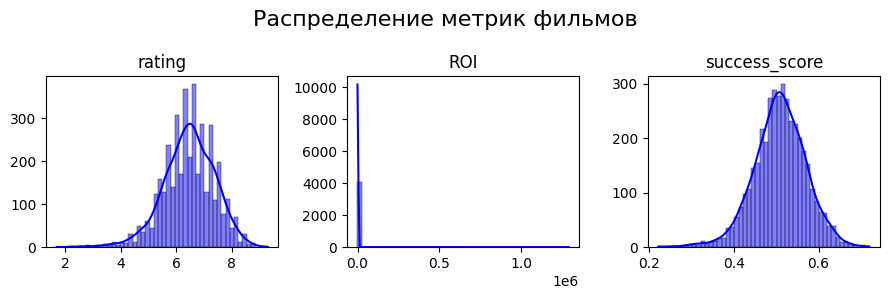

In [499]:
metrics = ['rating', 'ROI', 'success_score'] # 'gross_world' не стоит включать, нже показано почему

fig, axes = plt.subplots(1, 3, figsize=(9,3))  # 1 ряд, 5 колонок

for ax, metric in zip(axes, metrics):
    sns.histplot(df_4corr[metric],
                 bins=50,
                 color='blue',
                 edgecolor='black',
                 kde=True,
                 ax=ax)
    ax.set_title(metric)
    ax.set_xlabel('')
    ax.set_ylabel('')

fig.suptitle('Распределение метрик фильмов', fontsize=16)
plt.tight_layout()
plt.show()

В метрике ROI много выбросов, данные неравномерные, для нее посчитаем медианные значения, для остальных - с нормальным распределением, - среднее. 

In [500]:
# Почему не стоит учитывать сборы по миру gross_world
gross_yearly = df_4corr.groupby('year')['gross_world'].median().reset_index()

fig = px.line(
    gross_yearly, 
    x='year', 
    y='gross_world', 
    markers=True,
    title='Динамика мировых сборов по годам',
    labels={'gross_world': 'Мировые сборы', 'year': 'Год'}
)

fig.show()

In [501]:
year_data = (df_4corr.groupby('year')
                    .agg({'success_score':'mean',
                          'rating':'mean',
                          'ROI':'median'
                         })
.reset_index()
)

year_data['year_score'] = (
    0.6 * year_data['success_score'] +
    0.2 * year_data['rating'] +
    0.2 * year_data['ROI']
).round(2)

display(year_data.sort_values('year_score', ascending=False).head(5))

best_year = int(year_data.sort_values('year_score', ascending=False).iloc[0]['year'])
print(f'Лучший год: {best_year}.')

,year,success_score,rating,ROI,year_score
43,2019,0.531152,6.580808,296.521358,60.94
41,2017,0.529025,6.493000,266.791251,54.97
38,2014,0.534799,6.602000,266.250977,54.89
39,2015,0.525982,6.494000,259.050709,53.42
42,2018,0.526294,6.448980,252.573162,52.12


Лучший год: 2019.


**ИТОГ:** Самый успешный год - 2019, его годовая оценка составляет 60.94 балла. На втором месте с большим отрывом идет 2017. В топ-5 входят только годы из 2010-ых.

In [502]:
best_year_df = df_4corr[df_4corr['year'] == best_year]

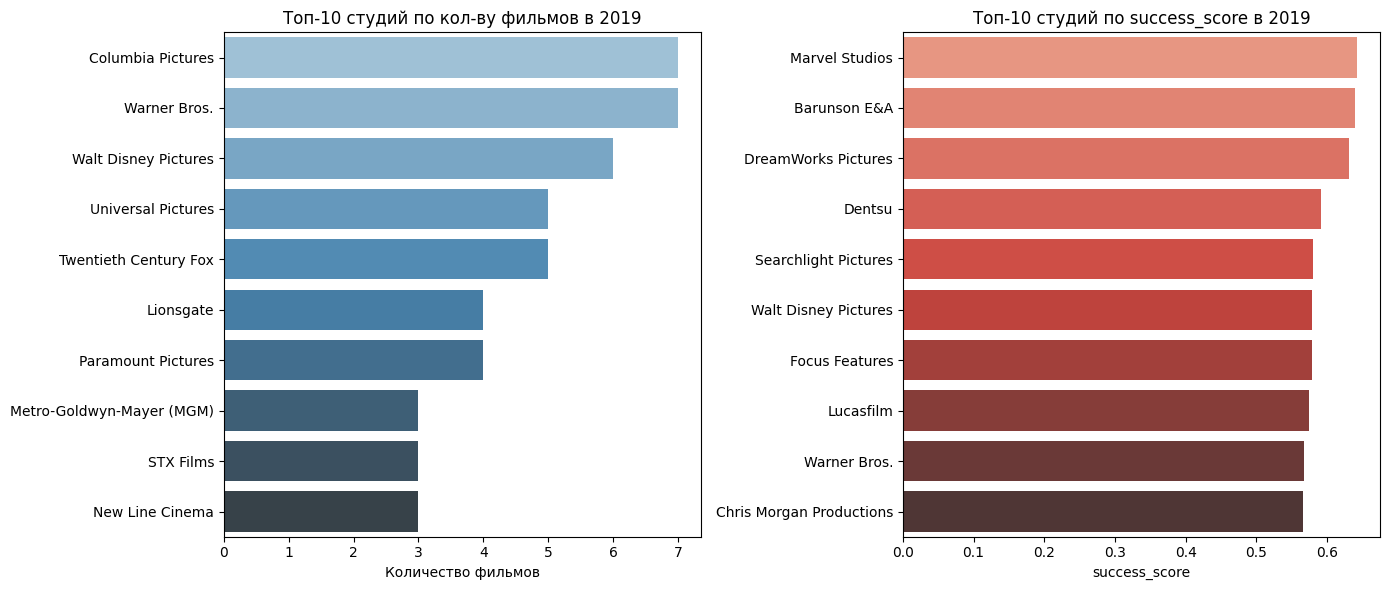

In [503]:
fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=best_year_df['company'].value_counts().head(10).values,
            y=best_year_df['company'].value_counts().head(10).index,
            ax=axes[0],
            palette='Blues_d'
           )
axes[0].set_title(f'Топ-10 студий по кол-ву фильмов в {best_year}')
axes[0].set_xlabel('Количество фильмов')
axes[0].set_ylabel('')

company_success = best_year_df.groupby('company')['success_score'].mean().sort_values(ascending=False).head(10)
sns.barplot(x=company_success.values,
            y=company_success.index,
            ax=axes[1],
            palette='Reds_d'
           )
axes[1].set_title(f'Топ-10 студий по success_score в {best_year}')
axes[1].set_xlabel('success_score')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


Больше всего фильмов вышли в 2019 году у Columbia Pictures и Warner Bros. (по 7 у каждой), в топ-3 так же Walt Disney Pictures (6 фильмов) и Universal Pictures, Twentieth Century Fox (5 фильмов) - все это крупные киностудии. 
Однако, если посмотреть на метрику успеха, то в самой успешной киностудией в 2019 году была Marvel Studios, хотя у нее вышло всего 2 фильма, они оказались успешными. Так же привлекает внимание киностудия Barunson E&A с 1 фильмом. Именно она выпустила фильм "Паразиты", который получил Оскар. Заслуженный успех :)

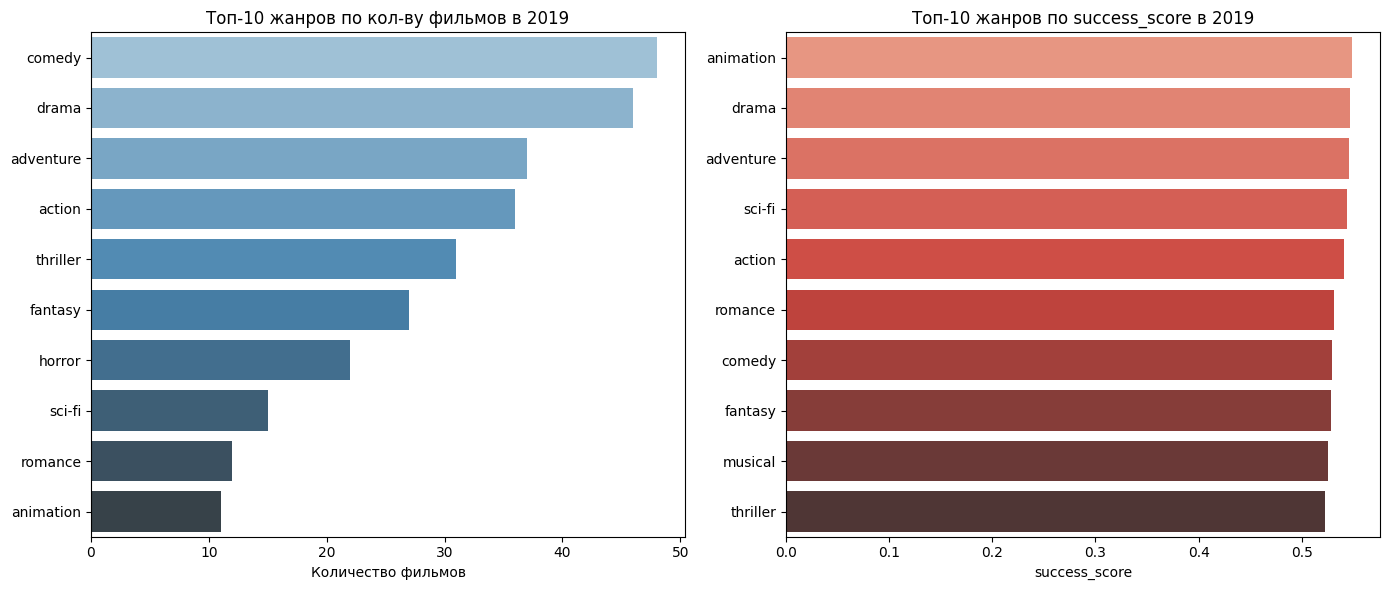

In [504]:
genres_expanded = best_year_df.explode('genre_base')

fig, axes = plt.subplots(1, 2, figsize=(14,6))

sns.barplot(x=genres_expanded['genre_base'].value_counts().head(10).values,
            y=genres_expanded['genre_base'].value_counts().head(10).index,
            ax=axes[0],
            palette='Blues_d'
           )
axes[0].set_title(f'Топ-10 жанров по кол-ву фильмов в {best_year}')
axes[0].set_xlabel('Количество фильмов')
axes[0].set_ylabel('')

genre_success = genres_expanded.groupby('genre_base')['success_score'].mean().sort_values(ascending=False).head(10)

sns.barplot(x=genre_success.values,
            y=genre_success.index,
            ax=axes[1],
            palette='Reds_d'
           )
axes[1].set_title(f'Топ-10 жанров по success_score в {best_year}')
axes[1].set_xlabel('success_score')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()


In [505]:
(genres_expanded[genres_expanded['genre_base'] == 'animation'][['title', 'success_score']]
    .sort_values('success_score', ascending=False)
    .head(3)
)

,title,success_score
4179,Toy Story 4,0.613777
4176,The Lion King,0.593156
4190,How to Train Your Dragon: The Hidden World,0.592079


По количеству жанров лидирует комедия и драма (более 45 фильмов), в топ-3 входит так же жанр приключения (37 фильмов). Но самым успешным жанром в 2019 году оказалась анимация. В этот год выши "История игрушек 4" (опять же, Оскар!), "Король лев", "Как приручить дракона" и другие известные анимационные фильмы. 

In [506]:
print("Фильм с самым высоким рейтингом: {}. рейтинг: {}".format(
        best_year_df.sort_values('rating', ascending=False).iloc[0]['title'],
        best_year_df.sort_values('rating', ascending=False).iloc[0]['rating']
    )
)

print("Фильм с самым высоким ROI: {}. ROI: {}".format(
        best_year_df.sort_values('ROI', ascending=False).iloc[0]['title'],
        best_year_df.sort_values('ROI', ascending=False).iloc[0]['ROI'].round(2)
    )
)
print(
    "Самый успешный фильм: {}. success_score: {}".format(
        best_year_df.sort_values('success_score', ascending=False).iloc[0]['title'],
        best_year_df.sort_values('success_score', ascending=False).iloc[0]['success_score'].round(2)
    )
)

Фильм с самым высоким рейтингом: Parasite. рейтинг: 8.5
Фильм с самым высоким ROI: Parasite. ROI: 2203.07
Самый успешный фильм: Avengers: Endgame. success_score: 0.7


### 3.6.1. Лучший год в истории кино - 2019!

На основании анализа выше, лучшим годом в кино оказался 2019.
В этом году наблюдалась высокая концентрация успешных фильмов с высокими оценками зрителей и хорошей окупаемостью.

Анализ студий показал, что топовые студии в 2019 году не только выпускали больше фильмов, но и добивались высокого среднего success_score, что свидетельствует о стратегически удачном выборе проектов.

По жанрам можно отметить, что доминировали классические жанры в виде комедий и драм, однако большего успеха добились фильме в жанре анимация.

В этом году вышло множество успешных фильмов, которые получили признание критиков и публики:
- Avengers: Endgame (Marvel Studios) — фильм с рекордными сборами, ставший кульминацией всей саги Marvel, сочетавший action и adventure.
- Joker (Warner Bros.) — драматический триллер, который вызвал широкий резонанс и получил высокую оценку критиков.
- Parasite (Barunson E&A) — международный успех, получивший Оскар за лучший фильм, доказавший, что качественное кино может так же быть коммерчески успешным.
- The Lion King (Walt Disney Pictures) и Frozen II	 (Walt Disney Pictures) — анимационные хиты, которые объединили зрительский успех и высокие рейтинги.

В целом, 2019 год характеризуется как год качественных и коммерчески успешных фильмов, объединяющий популярность среди зрителей и финансовую отдачу для студий.

## 3.7. Формула успешного кино.
На основе данных по всем фильмам и рассчитанной метрики success_score найдем итоговый профиль успешного фильма. 

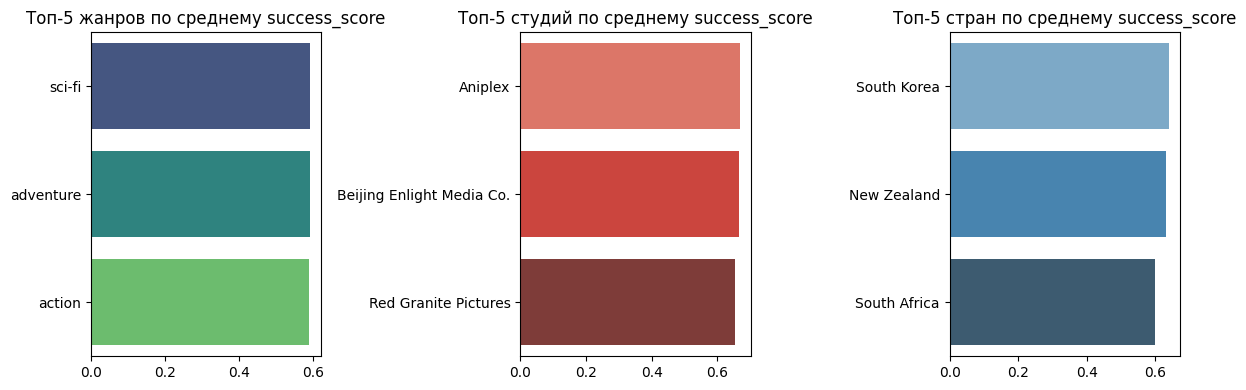

In [507]:
threshold = df_4corr['success_score'].quantile(0.75)  # берем только успешные фильмы
successful_films = df_4corr[df_4corr['success_score'] >= threshold]

genres_all = successful_films.explode('genre_base')
top_genres_score = genres_all.groupby('genre_base')['success_score'].mean().sort_values(ascending=False).head(3)

top_comp_score = successful_films.groupby('company')['success_score'].mean().sort_values(ascending=False).head(3)
top_countries_score = successful_films.groupby('origin_country')['success_score'].mean().sort_values(ascending=False).head(3)

fig, axes = plt.subplots(1, 3, figsize=(12,4))

sns.barplot(x=top_genres_score.values, y=top_genres_score.index, palette='viridis', ax=axes[0])
axes[0].set_title("Топ-5 жанров по среднему success_score")
axes[0].set_ylabel("")
axes[0].set_xlabel("")

sns.barplot(x=top_comp_score.values, y=top_comp_score.index, palette='Reds_d', ax=axes[1])
axes[1].set_title("Топ-5 студий по среднему success_score")
axes[1].set_ylabel("")
axes[1].set_xlabel("")

sns.barplot(x=top_countries_score.values, y=top_countries_score.index, palette='Blues_d', ax=axes[2])
axes[2].set_title("Топ-5 стран по среднему success_score")
axes[2].set_ylabel("")
axes[2].set_xlabel("")

plt.tight_layout()
plt.show()


In [508]:
print(f'Средняя длительность успешного фильма: {int(successful_films['duration'].mean().round(0))} минут.')
print(f'Медианный бюджет успешного фильма: $ {int(successful_films['budget'].median()):,}.')

Средняя длительность успешного фильма: 125 минут.
Медианный бюджет успешного фильма: $ 52,000,000.


In [509]:
duration_top = successful_films.copy()
bins_duration = range(75, 230, 25)
duration_top['duration_bin'] = pd.cut(successful_films['duration'], bins=bins_duration)
top_duration_score = duration_top.groupby('duration_bin')['success_score'].mean()

top_duration_score.index = [f"{int(interval.left)}-{int(interval.right)}" for interval in top_duration_score.index]


fig = px.bar(
    x=top_duration_score.index.astype(str),
    y=top_duration_score.values,
    labels={'x':'Длительность (мин)', 'y':'Успех'},
    title="Доля успешных фильмов по длительности",
    color=top_duration_score.values,
    color_continuous_scale='Purples'
)
fig.show()



In [510]:
successful_films['budget_log'] = successful_films['budget'].apply(lambda x: np.log10(x) if x > 0 else 0)
fig = px.scatter(
    successful_films,
    x='budget_log',
    y='success_score',
    color = 'year',
    opacity=0.6,
    title='Корреляция бюджета и success_score',
    labels={'budget_log': 'Бюджет log', 'year': 'Год'},
    width=1100,
    height=600
)

fig.show()

### 3.7.1 Профиль успешного фильма

На основе анализа фильмов с высоким success_score был составлен итоговый профиль успешного фильма.

1. Бюджет. Большинство успешных фильмов имеют крупный бюджет, что позволяет реализовать высококачественные спецэффекты, пригласить известных актеров и обеспечить широкую дистрибуцию, однако есть проекты с более консервативным бюджетом.
2. Длительность фильма. Оптимальная продолжительность успешных фильмов - около 2 часов. Это достаточно для раскрытия сюжета, но не слишком длинно, чтобы терять внимание аудитории.
3. Жанры. Жанры sci-fi, action, adventure чаще всего имеют успех. Вероятно, динамичные сюжеты, зрелищные сцены и массовая аудитория способствуют коммерческому успеху.
4. Киностудии. Не всегда большие киностудии - залог успеха. Можно снимать в инди-киностудиях.
5. Страны. Больше всего зрителям нравятся фильмы из Южной Кореи и Новой Зеландии.

Формула успешного кино

- Длительность фильма: 125 минут.
- Бюджет: 52 млн долларов.
- Съемки в Южной Корее или Новой Зеландии
- Жанр sci-fi, action, adventure.
- Студия - любая, даже инди. 

---